<a href="https://colab.research.google.com/github/Cesare-Caputo/PyPSA-gridtracer/blob/main/pypsa_gridtracer_v3_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# setup

In [ ]:
!pip install geopandas rtree
!pip install rasterio

     |████████████████████████████████| 1.0 MB 9.0 MB/s 
     |████████████████████████████████| 1.0 MB 45.1 MB/s 
     |████████████████████████████████| 16.7 MB 276 kB/s 
     |████████████████████████████████| 6.3 MB 39.4 MB/s 
     |████████████████████████████████| 19.3 MB 2.2 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
datapath = '/content/drive/MyDrive/PyPSA_Africa_images/datasets'

import sys
sys.argv = ['']


# Add pypsa africa tool
import os

import sys
sys.path.append('/content/drive/MyDrive/PyPSA_Africa_images/detect_energy/src/')


from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt



import os
os.chdir('/content/drive/My Drive/PyPSA_Africa_images/')
import importlib
import sys
sys.path.append(os.getcwd()+'/detect_energy/image_download/')
import geopandas as gpd
import pandas as pd

from pathlib import Path
folder_out = Path('test_output')
guess_skeletonized_out = folder_out / 'guess_skel.tif'



from heapq import heapify, heappush, heappop
import pickle
import rasterio
from IPython.display import display, Markdown
from math import sqrt
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd
from skimage.morphology import skeletonize
import shapely.wkt
from shapely.geometry import Point, LineString, MultiLineString
import rasterio
from rasterio.features import rasterize
from rasterio.transform import xy

import folium

from sklearn.cluster import DBSCAN
import time
from sklearn import metrics
from sklearn.ensemble import IsolationForest

# helper functions

##cleanup/outliar detection

In [ ]:
def identify_outliers_DBSCAN(df,eps = 1.5e-2 ,min_samples = 6):
    gh_twr_df = df
    gh_twr_df['lon'] = gh_twr_df.geometry.apply(lambda p: p.x)
    gh_twr_df['lat'] = gh_twr_df.geometry.apply(lambda p: p.y)

    # represent points consistently as (lat, lon)
    coords_df = gh_twr_df[['lat', 'lon']]

    outlier_detection = DBSCAN(eps = eps, min_samples = min_samples)
    clusters = outlier_detection.fit_predict(coords_df)
    data = pd.DataFrame()
    data['cluster'] = clusters
    return data['cluster']

def cleanup_twr_df_DBSCAN(df,eps = 1.5e-2 ,min_samples = 6):
    clusters=identify_outliers_DBSCAN(df,eps,min_samples)
    df_cluster=pd.DataFrame(clusters)
    ind_outlier=df_cluster.index[df_cluster['cluster']==-1]
    for i in ind_outlier:
      df_final = df.drop(ind_outlier)
    return df_final


def indentify_outliers_IF(df, n_estimators=5, warm_start=True):
    clf = IsolationForest(n_estimators=n_estimators, warm_start=True)
    X = df.to_numpy()
    clf.fit(X)
    labels_if = clf.predict(X)
    clusters = labels_if
    data = pd.DataFrame()
    data['cluster'] = clusters
    return data['cluster']



def remove_gt_inferred_outliers_DBSCAN(df,inferred_df, eps = 1.5e-1 ,min_samples= 5):

    gh_twr_df = df
    gh_twr_df['lon'] = gh_twr_df.geometry.apply(lambda p: p.x)
    gh_twr_df['lat'] = gh_twr_df.geometry.apply(lambda p: p.y)

    # represent points consistently as (lat, lon)
    pts_coords_df = gh_twr_df[['lat', 'lon']]



    inferred_df = lines_guess_gdf_stoch
    # now same for lines
    lines_guess_gdf_stoch['lon'] = lines_guess_gdf_stoch.geometry.centroid.apply(lambda p: p.x)
    lines_guess_gdf_stoch['lat'] = lines_guess_gdf_stoch.geometry.centroid.apply(lambda p: p.y)

    lines_coords_df = lines_guess_gdf_stoch[['lat', 'lon']]

    db_scan_model = DBSCAN(eps = eps, min_samples = min_samples)

    outlier_detection = db_scan_model.fit(lines_coords_df)

    clusters_pts = outlier_detection.fit_predict(pts_coords_df)

    data = pd.DataFrame()
    data['cluster'] = clusters_pts
    df_cluster=pd.DataFrame(data['cluster'])
    ind_outlier=df_cluster.index[df_cluster['cluster']==-1]
    ind_outlier


    df = gh_twr_df
    for i in ind_outlier:
      clean_df = df.drop(ind_outlier)

    return clean_df

## pre

Mostly utils for geoconversions, some redudancy but no time to clean up for now

In [ ]:
# note that these are for now specific to extrating tower data
def gdf_2_gridded_conversion(gdf, n_cells):
    xmin, ymin, xmax, ymax= gdf.total_bounds
  # how many cells for range of x values investigated - can be customized for y if needed
  #n_cells=30
    cell_size = (xmax-xmin)/n_cells
    # projection of the grid
    crs = "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"
    # create the cells in a loop
    grid_cells = []
    for x0 in np.arange(xmin, xmax+cell_size, cell_size ):
        for y0 in np.arange(ymin, ymax+cell_size, cell_size):
            # bounds
            x1 = x0-cell_size
            y1 = y0+cell_size
            grid_cells.append( shapely.geometry.box(x0, y0, x1, y1)  )
    cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'],
                                    crs=crs)


    merged = gpd.sjoin(gdf, cell, how='left', op='within')

    #clean_merge = merged.drop(labels =['tags.power', 'tags.material', 'tags.height', 'tags.structure',
        #'tags.line_management', 'Type', 'Country'], axis = 1)

    #clean_merge = merged.drop(labels =['tags.power', 'Type', 'Country'], axis = 1)
    clean_merge = merged.loc[:, ['id', 'geometry', 'index_right']]
    ## removing nan which can cause error
    merged2 = clean_merge.dropna(axis = 0, how = 'any')

    return merged2 , cell

def gdf_2_binary_gridded_conversion(gdf, n_cells):
    merged2, cell = gdf_2_gridded_conversion(gdf, n_cells)

    # make a simple count variable that we can sum
    merged2['n_twr']=1
    # Compute stats per grid cell -- aggregate fires to grid cells with dissolve
    dissolve = merged2.dissolve(by="index_right", aggfunc="count")
    # put this into cell
    cell.loc[dissolve.index, 'n_twr'] = dissolve.n_twr.values


    return cell


def line_gdf_2_gridded_conversion(gdf, n_cells):
    xmin, ymin, xmax, ymax= gdf.total_bounds
  # how many cells for range of x values investigated - can be customized for y if needed
  #n_cells=30
    cell_size = (xmax-xmin)/n_cells
    # projection of the grid
    crs = "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"
    # create the cells in a loop
    grid_cells = []
    for x0 in np.arange(xmin, xmax+cell_size, cell_size ):
        for y0 in np.arange(ymin, ymax+cell_size, cell_size):
            # bounds
            x1 = x0-cell_size
            y1 = y0+cell_size
            grid_cells.append( shapely.geometry.box(x0, y0, x1, y1)  )
    cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'],
                                    crs=crs)


    merged = gpd.sjoin(gdf, cell, how='left', op='within')

    #clean_merge = merged.drop(labels =['tags.power', 'tags.cables', 'tags.voltage', 'tags.frequency',
        #'Type', 'Country'], axis = 1)

    clean_merge = merged
    ## removing nan which can cause error
    merged2 = clean_merge.dropna(axis = 0, how = 'any')

    return merged2 , cell

def line_gdf_2_binary_gridded_conversion(gdf, n_cells):
    merged2, cell = line_gdf_2_gridded_conversion(gdf, n_cells)

    # make a simple count variable that we can sum
    merged2['n_lines']=1
    # Compute stats per grid cell -- aggregate fires to grid cells with dissolve
    dissolve = merged2.dissolve(by="index_right", aggfunc="count")
    # put this into cell
    cell.loc[dissolve.index, 'n_lines'] = dissolve.n_lines.values


    return cell

# note that these are for now specific to extrating tower data
def guess_line_gdf_2_gridded_conversion(gdf, true_line_df, n_cells):
    xmin, ymin, xmax, ymax= gdf.total_bounds
  # how many cells for range of x values investigated - can be customized for y if needed
    cell_size = (xmax-xmin)/n_cells
    # projection of the grid
    crs = "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"
    # create the cells in a loop
    grid_cells = []
    for x0 in np.arange(xmin, xmax+cell_size, cell_size ):
        for y0 in np.arange(ymin, ymax+cell_size, cell_size):
            # bounds
            x1 = x0-cell_size
            y1 = y0+cell_size
            grid_cells.append( shapely.geometry.box(x0, y0, x1, y1)  )
    cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'],
                                    crs=crs)


    merged = gpd.sjoin(gdf, cell, how='left', op='within')

    #clean_merge = merged.drop(labels =['tags.power', 'tags.cables', 'tags.voltage', 'tags.frequency',
        #'Type', 'Country'], axis = 1)

    clean_merge = merged
    ## removing nan which can cause error
    merged2 = clean_merge.dropna(axis = 0, how = 'any')

    return merged2 , cell

def guess_line_gdf_2_binary_gridded_conversion(gdf, true_line_df, n_cells):
    merged2, cell = guess_line_gdf_2_gridded_conversion(gdf, true_line_df, n_cells)

    # make a simple count variable that we can sum
    merged2['n_lines']=1
    # Compute stats per grid cell -- aggregate fires to grid cells with dissolve
    dissolve = merged2.dissolve(by="index_right", aggfunc="count")
    # put this into cell
    cell.loc[dissolve.index, 'n_lines'] = dissolve.n_lines.values


    return cell


# note that these are for now specific to extrating tower data
def guess_line_gdf_2_gridded_conversion(gdf, true_line_df, n_cells):
    xmin, ymin, xmax, ymax= gdf.total_bounds
  # how many cells for range of x values investigated - can be customized for y if needed
    cell_size = (xmax-xmin)/n_cells
    # projection of the grid
    crs = "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"
    # create the cells in a loop
    grid_cells = []
    for x0 in np.arange(xmin, xmax+cell_size, cell_size ):
        for y0 in np.arange(ymin, ymax+cell_size, cell_size):
            # bounds
            x1 = x0-cell_size
            y1 = y0+cell_size
            grid_cells.append( shapely.geometry.box(x0, y0, x1, y1)  )
    cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'],
                                    crs=crs)


    merged = gpd.sjoin(gdf, cell, how='left', op='within')

    #clean_merge = merged.drop(labels =['tags.power', 'tags.cables', 'tags.voltage', 'tags.frequency',
        #'Type', 'Country'], axis = 1)

    clean_merge = merged
    ## removing nan which can cause error
    merged2 = clean_merge.dropna(axis = 0, how = 'any')

    return merged2 , cell

def guess_line_gdf_2_binary_gridded_conversion(gdf, true_line_df, n_cells):
    merged2, cell = guess_line_gdf_2_gridded_conversion(gdf, true_line_df, n_cells)

    # make a simple count variable that we can sum
    merged2['n_lines']=1
    # Compute stats per grid cell -- aggregate fires to grid cells with dissolve
    dissolve = merged2.dissolve(by="index_right", aggfunc="count")
    # put this into cell
    cell.loc[dissolve.index, 'n_lines'] = dissolve.n_lines.values


    return cell



def m_distance_sline_all_towers(gh_coord_test):
  gh_coord_test_crs = gh_coord_test.to_crs('EPSG:5234')
  gh_coord_test_crs2 = gh_coord_test_crs.shift()
  dists =[]
  for gv in range(len(gh_coord_test_crs)):
    pt = gh_coord_test_crs[gv]
    dists.append(gh_coord_test_crs.distance(pt))
  return dists

def unpack_all_tower_coords(gh_coord_test):
  labeled_twr_coords =[]
  for i in range(len(gh_coord_test.geometry)):
      i_coord = list(gh_coord_test.geometry.iloc[i].coords)
      mylist_n = [j for i in i_coord for j in i] # unpack list so linestring format compatible with EE
      labeled_twr_coords.append(mylist_n)
  return labeled_twr_coords



def return_idx_lines_gridded(cell, n_cells): #cell here is df containing both shapely polygon grids and original tower point markers , ncells to number of cells in x coordinate system for now
  # total area for the grid
  gdf = cell
  xmin, ymin, xmax, ymax= gdf.total_bounds
  cell_size = (xmax-xmin)/n_cells

  gps = []
  #find location in grid ####
  for i in range(len(cell)):
    if cell["n_lines"][i] ==1:
      #print(i)
      twr_grid_cnt = list(cell.iloc[i].geometry.centroid.coords)
      yic = twr_grid_cnt[0][1]
      xic = twr_grid_cnt[0][0]
  #### now retrieve integer indexing #####
      yi = int((yic- ymin) / cell_size)
      xi = int((xic- xmin) / cell_size)

      gps.append((yi,xi))
  return gps


def return_idx_twr_gridded(cell, n_cells): #cell here is df containing both shapely polygon grids and original tower point markers , ncells to number of cells in x coordinate system for now
  # total area for the grid
  gdf = cell
  xmin, ymin, xmax, ymax= gdf.total_bounds
  cell_size = (xmax-xmin)/n_cells

  gps = []
  #find location in grid ####
  for i in range(len(cell)):
    if cell["n_twr"][i] ==1:
      #print(i)
      twr_grid_cnt = list(cell.iloc[i].geometry.centroid.coords)
      yic = twr_grid_cnt[0][1]
      xic = twr_grid_cnt[0][0]
  #### now retrieve integer indexing #####
      yi = int((yic- ymin) / cell_size)
      xi = int((xic- xmin) / cell_size)

      gps.append((yi,xi))
  return gps



def lines_df_to_2d_target_array(cell, n_cells):

  gdf = cell
  xmin, ymin, xmax, ymax= gdf.total_bounds
  cell_size = (xmax-xmin)/n_cells

  # define number of x and y cells used for indexing
  nxcell = int((xmax - xmin) / cell_size)
  nycell = int((ymax - ymin) / cell_size)

  twr_pts_idx = return_idx_lines_gridded(cell, n_cells)

  points = twr_pts_idx
  targets = np.zeros((int(nycell+1), int(nxcell+1)))
  targets[tuple(np.array(points).T)] = 1
  #targets[tuple(np.array(points))] = 1
  #equal costs for all cells - excluding road info etc
  costs = np.ones((int(nycell+1), int(nxcell+1)))

  ## flip to be consistent with original gridded
  t = np.flip(targets, 0)
  c = np.flip(costs, 0)

  return t, c


def lines_df_to_2d_target_array2(cell, truth_cell, n_cells):

  gdf = truth_cell
  xmin, ymin, xmax, ymax= gdf.total_bounds
  cell_size = (xmax-xmin)/n_cells

  # define number of x and y cells used for indexing
  nxcell = int((xmax - xmin) / cell_size)
  nycell = int((ymax - ymin) / cell_size)

  twr_pts_idx = return_idx_lines_gridded(cell, n_cells)

  points = twr_pts_idx
  targets = np.zeros((int(nycell+1), int(nxcell+1)))
  targets[tuple(np.array(points).T)] = 1
  #targets[tuple(np.array(points))] = 1
  #equal costs for all cells - excluding road info etc
  costs = np.ones((int(nycell+1), int(nxcell+1)))

  ## flip to be consistent with original gridded
  t = np.flip(targets, 0)
  c = np.flip(costs, 0)

  return t, c


def pts_df_to_2d_target_array(cell, n_cells):

  gdf = cell
  xmin, ymin, xmax, ymax= gdf.total_bounds
  cell_size = (xmax-xmin)/n_cells

  # define number of x and y cells used for indexing
  nxcell = int((xmax - xmin) / cell_size)
  nycell = int((ymax - ymin) / cell_size)

  twr_pts_idx = return_idx_twr_gridded(cell, n_cells)

  points = twr_pts_idx
  targets = np.zeros((int(nycell+1), int(nxcell+1)))
  targets[tuple(np.array(points).T)] = 1
  #targets[tuple(np.array(points))] = 1
  #equal costs for all cells - excluding road info etc
  costs = np.ones((int(nycell+1), int(nxcell+1)))

  ## flip to be consistent with original gridded
  t = np.flip(targets, 0)
  c = np.flip(costs, 0)

  return t, c


def linestring_to_points(line):
    return line.coords


def line_2_pts_geodf(gdf):
  from shapely.geometry import MultiPoint

  split_line_pt_guess_df = gdf.explode(ignore_index = True)
  split_line_pt_guess_df['points'] = split_line_pt_guess_df.apply(lambda l: linestring_to_points(l['geometry']),axis=1)
  split_line_pt_guess_df['multi_points'] = split_line_pt_guess_df.apply(lambda l: MultiPoint(l['points']),axis=1)
  a = split_line_pt_guess_df['multi_points'].explode(ignore_index = True)
  final_guess_pt_df = gpd.GeoDataFrame(geometry = a)
  return final_guess_pt_df

def get_line_points_intersection(lines):
    point_intersections = []
    lines_len = len(lines)
    for i in range(lines_len):
        for j in range(i+1, lines_len): #to avoid computing twice the same intersection we do some index handling
            l1, l2 = lines[i], lines[j]
            if l1.intersects(l2):
                intersection = l1.intersection(l2)
                point_intersections.append(intersection)

    return point_intersections


##post

In [ ]:
def save_raster(path, raster, affine, crs=None, nodata=0):
    """Save a raster to the specified file.
    Parameters
    ----------
    file : str
        Output file path
    raster : numpy.array
        2D numpy array containing raster values
    affine: affine.Affine
        Affine transformation for the raster
    crs: str, proj.Proj, optional (default EPSG4326)
        CRS for the raster
    """

    path = Path(path)
    if not path.parents[0].exists():
        path.parents[0].mkdir(parents=True, exist_ok=True)

    if not crs:
        crs = "+proj=latlong"

    filtered_out = rasterio.open(
        path,
        "w",
        driver="GTiff",
        height=raster.shape[0],
        width=raster.shape[1],
        count=1,
        dtype=raster.dtype,
        crs=crs,
        transform=affine,
        nodata=nodata,
    )
    filtered_out.write(raster, 1)
    filtered_out.close()



# converting outputs from alkgoirthm numpy arrrat form back to geodataframr

def convert_guess_to_gdf_multilines(thinned_network_guess, original_gdf, n_cells):

  gdf = original_gdf
  xmin, ymin, xmax, ymax= gdf.total_bounds
  cell_size = (xmax-xmin)/n_cells

  #arr = network_guess
  arr = np.flip(thinned_network_guess,0)

  max_row = arr.shape[0]
  max_col = arr.shape[1]

  lines = []

  for row in range(0, max_row):
      for col in range(0, max_col):
          loc = (row, col)
          if arr[loc] == 1:
              for i in range(-1, 2):
                  for j in range(-1, 2):
                      next_row = row + i
                      next_col = col + j
                      next_loc = (next_row, next_col)

                      # ensure we're within bounds
                      # ensure we're not looking at the same spot
                      if (
                          next_row < 0
                          or next_col < 0
                          or next_row >= max_row
                          or next_col >= max_col
                          or next_loc == loc
                      ):
                          continue

                      if arr[next_loc] == 1:
                          line = (loc, next_loc)
                          rev = (line[1], line[0])
                          if line not in lines and rev not in lines:
                              lines.append(line)


  real_lines = []
  for line in lines:
      xi = line[0][1]
      yi = line[0][0]
      ycoord = yi*cell_size + ymin
      xcoord = xi*cell_size + xmin
  #second set of points
      xi2 = line[1][1]
      yi2 = line[1][0]
      ycoord2 = yi2*cell_size + ymin
      xcoord2 = xi2*cell_size + xmin


      real =((xcoord, ycoord), (xcoord2, ycoord2))
      real_lines.append(real)


  shapes = []
  for line in real_lines:
    #print(line[1])
    shapes.append(LineString([Point(line[0]), Point(line[1])]).wkt)


  guess_gdf = pd.DataFrame(shapes)
  geometry = guess_gdf[0].map(shapely.wkt.loads)
  guess_gdf = guess_gdf.drop(0, axis=1)
  guess_gdf = gpd.GeoDataFrame(guess_gdf, geometry=geometry)

  guess_gdf = guess_gdf.set_crs('epsg:4326')

  guess_gdf["same"] = 0
  guess_gdf = guess_gdf.dissolve(by="same")
  guess_gdf = guess_gdf.to_crs(epsg=4326)

  return guess_gdf

def convert_guess_to_gdf_multilines2(thinned_network_guess, original_gdf, n_cells, treshold = .05):

  gdf = original_gdf
  xmin, ymin, xmax, ymax= gdf.total_bounds
  cell_size = (xmax-xmin)/n_cells

  #arr = network_guess
  arr = np.flip(thinned_network_guess,0)

  max_row = arr.shape[0]
  max_col = arr.shape[1]

  lines = []

  for row in range(0, max_row):
      for col in range(0, max_col):
          loc = (row, col)
          #if arr[loc] == 1:
          if arr[loc] >= treshold:
              for i in range(-1, 2):
                  for j in range(-1, 2):
                      next_row = row + i
                      next_col = col + j
                      next_loc = (next_row, next_col)

                      # ensure we're within bounds
                      # ensure we're not looking at the same spot
                      if (
                          next_row < 0
                          or next_col < 0
                          or next_row >= max_row
                          or next_col >= max_col
                          or next_loc == loc
                      ):
                          continue

                      if arr[next_loc] == 1:
                          line = (loc, next_loc)
                          rev = (line[1], line[0])
                          if line not in lines and rev not in lines:
                              lines.append(line)


  real_lines = []
  for line in lines:
      xi = line[0][1]
      yi = line[0][0]
      ycoord = yi*cell_size + ymin
      xcoord = xi*cell_size + xmin
  #second set of points
      xi2 = line[1][1]
      yi2 = line[1][0]
      ycoord2 = yi2*cell_size + ymin
      xcoord2 = xi2*cell_size + xmin


      real =((xcoord, ycoord), (xcoord2, ycoord2))
      real_lines.append(real)


  shapes = []
  for line in real_lines:
    #print(line[1])
    shapes.append(LineString([Point(line[0]), Point(line[1])]).wkt)


  guess_gdf = pd.DataFrame(shapes)
  geometry = guess_gdf[0].map(shapely.wkt.loads)
  guess_gdf = guess_gdf.drop(0, axis=1)
  guess_gdf = gpd.GeoDataFrame(guess_gdf, geometry=geometry)

  guess_gdf = guess_gdf.set_crs('epsg:4326')

  guess_gdf["same"] = 0
  guess_gdf = guess_gdf.dissolve(by="same")
  guess_gdf = guess_gdf.to_crs(epsg=4326)

  return guess_gdf


def convert_guess_to_gdf_pts(thinned_network_guess, original_gdf, n_cells):
  gdf = original_gdf
  xmin, ymin, xmax, ymax= gdf.total_bounds
  cell_size = (xmax-xmin)/n_cells
  arr = thinned_network_guess

  max_row = arr.shape[0]
  max_col = arr.shape[1]

  lines = []
  line_pts = []

  for row in range(0, max_row):
      for col in range(0, max_col):
          loc = (row, col)
          if arr[loc] == 1:
            line_pts.append(loc)


  real_lines_pts = []
  for line in line_pts:
      xi = line[1]
      yi = line[0]
      ycoord = yi*cell_size + ymin
      xcoord = xi*cell_size + xmin

      real =(xcoord, ycoord)
      real_lines_pts.append(real)


  shapes = []
  for line in real_lines_pts:
    #print(line[1])
    shapes.append(Point(line[0],line[1]).wkt)


  guess_gdf = pd.DataFrame(shapes)
  geometry = guess_gdf[0].map(shapely.wkt.loads)
  guess_gdf = guess_gdf.drop(0, axis=1)
  guess_gdf = gpd.GeoDataFrame(guess_gdf, geometry=geometry)

  guess_gdf = guess_gdf.set_crs('epsg:4326')

  guess_gdf["same"] = 0
  guess_gdf = guess_gdf.dissolve(by="same")
  guess_gdf = guess_gdf.to_crs(epsg=4326)
  return guess_gdf

##follium labeling

In [ ]:
from branca.element import Template, MacroElement
### function  was not working welll so doing this bvery unelegant version for now
gh_template_100 = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>

  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>


<div id='maplegend' class='maplegend'
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>

<div class='legend-title'>Ghana Electricity Grid</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:blue;opacity:0.7;'></span>Inferred 100 Cells </li>
    <li><span style='background:orange;opacity:0.7;'></span>OSM Ground Truth</li>

  </ul>
</div>
</div>

</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""


gh_template_300 = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>

  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>


<div id='maplegend' class='maplegend'
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>

<div class='legend-title'>Ghana Electricity Grid</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:blue;opacity:0.7;'></span>Inferred 300 Cells </li>
    <li><span style='background:orange;opacity:0.7;'></span>OSM Ground Truth</li>

  </ul>
</div>
</div>

</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""


gh_template_500 = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>

  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>


<div id='maplegend' class='maplegend'
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>

<div class='legend-title'>Ghana Electricity Grid</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:blue;opacity:0.7;'></span>Inferred 500 Cells </li>
    <li><span style='background:orange;opacity:0.7;'></span>OSM Ground Truth</li>

  </ul>
</div>
</div>

</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""


gh_template_1000 = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>

  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>


<div id='maplegend' class='maplegend'
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>

<div class='legend-title'>Ghana Electricity Grid</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:blue;opacity:0.7;'></span>Inferred 1000 Cells </li>
    <li><span style='background:orange;opacity:0.7;'></span>OSM Ground Truth</li>

  </ul>
</div>
</div>

</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

# PyPSA Gridfinder

## Djikstra Shortest path

In [ ]:
def optimise(
    targets,
    costs,
    start,
    jupyter=False,
    animate=True,
    affine=None,
    animate_path=None,
    silent=False,
):
    """Run the Dijkstra algorithm for the supplied arrays.
    Parameters
    ----------
    targets : numpy array
        2D array of targets which includes only towers for now. Will be extended to towns and villages in v2.
    costs : numpy array
        2D array of costs. These are initialised all to 1 for now but will include cost based on osm road data in v2.
    start : tuple
        Two-element tuple with row, col of starting point.
    jupyter : boolean, optional (default False)
        Whether the code is being run from a Jupyter Notebook.
    Returns
    -------
    dist : numpy array
        2D array with the distance (in cells) of each point from a 'found'
        on-grid point. Values of 0 imply that cell is part of a grid line.
    """

    max_i = costs.shape[0]
    max_j = costs.shape[1]

    visited = np.zeros_like(targets, dtype=np.int8)
    dist = np.full_like(costs, np.nan, dtype=np.float32)

    # want to set this to dtype='int32, int32'
    # but then the if type(prev_loc) == tuple check will break
    # becuas it gets instantiated with tuples
    prev = np.full_like(costs, np.nan, dtype=object)

    dist[start] = 0

    #       dist, loc
    queue = [[0, start]]
    heapify(queue)

    def zero_and_heap_path(loc):
        """Zero the location's distance value and follow upstream doing same.
        Parameters
        ----------
        loc : tuple
            row, col of current point.
        """

        if not dist[loc] == 0:
            dist[loc] = 0
            visited[loc] = 1

            heappush(queue, [0, loc])
            prev_loc = prev[loc]

            if type(prev_loc) == tuple:
                zero_and_heap_path(prev_loc)

    counter = 0
    progress = 0
    max_cells = targets.shape[0] * targets.shape[1]
    if jupyter:
        handle = display(Markdown(""), display_id=True)

    while len(queue):
        current = heappop(queue)
        current_loc = current[1]
        current_i = current_loc[0]
        current_j = current_loc[1]
        current_dist = dist[current_loc]

        for x in range(-1, 2):
            for y in range(-1, 2):
                next_i = current_i + x
                next_j = current_j + y
                next_loc = (next_i, next_j)

                # ensure we're within bounds
                if next_i < 0 or next_j < 0 or next_i >= max_i or next_j >= max_j:
                    continue

                # ensure we're not looking at the same spot
                if next_loc == current_loc:
                    continue

                # skip if we've already set dist to 0
                if dist[next_loc] == 0:
                    continue

                # if the location is connected
                if targets[next_loc]:
                    prev[next_loc] = current_loc
                    zero_and_heap_path(next_loc)

                # otherwise it's a normal queue cell
                else:
                    dist_add = costs[next_loc]
                    if x == 0 or y == 0:  # if this cell is  up/down/left/right
                        dist_add *= 1
                    else:  # or if it's diagonal
                        dist_add *= sqrt(2)

                    next_dist = current_dist + dist_add

                    if visited[next_loc]:
                        if next_dist < dist[next_loc]:
                            dist[next_loc] = next_dist
                            prev[next_loc] = current_loc
                            heappush(queue, [next_dist, next_loc])

                    else:
                        heappush(queue, [next_dist, next_loc])
                        visited[next_loc] = 1
                        dist[next_loc] = next_dist
                        prev[next_loc] = current_loc

                        counter += 1
                        progress_new = 100 * counter / max_cells
                        if int(progress_new) > int(progress):
                            progress = progress_new
                            message = f"{progress:.2f} %"
                            if jupyter:
                                handle.update(message)
                            elif not silent:
                                print(message)
                            if animate:
                                i = int(progress)
                                path = os.path.join(animate_path, f"arr{i:03d}.tif")
                                save_raster(path, dist, affine)

    return dist


def threshold(dists_in, cutoff=0.5):
    """Convert distance array into binary array of connected locations.
    Parameters
    ----------
    dists_in : path-like or numpy array
        2D array output from gridfinder algorithm.
    cutoff : float, optional (default 0.5.)
        Cutoff value below which consider the cells to be grid.
    Returns
    -------
    guess : numpy array
        Binary representation of input array.
    affine: affine.Affine
        Affine transformation for raster.
    """
    if isinstance(dists_in, (str, Path)):
        dists_rd = rasterio.open(dists_in)
        dists_r = dists_rd.read(1)
        affine = dists_rd.transform

        guess = dists_r.copy()
        guess[dists_r > cutoff] = 0
        guess[dists_r <= cutoff] = 1

        return guess, affine

    elif isinstance(dists_in, np.ndarray):
        guess = dists_in.copy()
        guess[dists_in > cutoff] = 0
        guess[dists_in <= cutoff] = 1

        return guess

    else:
        raise ValueError


def thin(guess_in):
    """
    Use scikit-image skeletonize to 'thin' the guess raster.
    Parameters
    ----------
    guess_in : path-like or 2D array
        Output from threshold().
    Returns
    -------
    guess_skel : numpy array
        Thinned version.
    affine : Affine
        Only if path-like supplied.
    """

    if isinstance(guess_in, (str, Path)):
        guess_rd = rasterio.open(guess_in)
        guess_arr = guess_rd.read(1)
        affine = guess_rd.transform

        guess_skel = skeletonize(guess_arr)
        guess_skel = guess_skel.astype("int32")

        return guess_skel, affine

    elif isinstance(guess_in, np.ndarray):
        guess_skel = skeletonize(guess_in)
        guess_skel = guess_skel.astype("int32")

        return guess_skel

    else:
        raise ValueError

## Cell number Inference functions

In [ ]:
def network_inference_array_v2(gdf, n_cells, random_start = True ):
    """ Calculate the most likely network structure in Numpy 2d array format output from algorithm. Values of 1 correspond to cells with grid, 0 with not.

        Parameters
        ----------
        gdf = GeoDataframe containing the locations of different towers available, each represented as a single shapely Point.

        n_cells = number of cells to split are investigated into to run gridfinder algo. More cells are more accurate but take much longer to run.


        Returns
        -------

        guess = Network inferred in 2D array format
        guess_skel = Skeletonized/thinned version of network inferred in 2D array format

    """

    cell = gdf_2_binary_gridded_conversion(gdf, n_cells)

  #### obtain 2d numpy representation to run gridfinder algo
    targets, costs = pts_df_to_2d_target_array(cell, n_cells)

    target_list = np.argwhere(targets == 1.0)

    if random_start == True:
      random_idx = np.random.randint(1,len(target_list))
      start = tuple(target_list[random_idx].tolist())
    else:
      start = tuple(target_list[0].tolist())

    dist = optimise(targets, costs, start, jupyter=True)

    guess = threshold(dist)

    guess_skel = thin(guess)

    return guess, guess_skel



In [ ]:
def network_inference_array_v3(gdf, n_cells, random_start = True , multiple_starts = 3):
    """ Calculate the most likely network structure in Numpy 2d array format output from algorithm. Values of 1 correspond to cells with grid, 0 with not.

        Parameters
        ----------
        gdf = GeoDataframe containing the locations of different towers available, each represented as a single shapely Point.

        n_cells = number of cells to split are investigated into to run gridfinder algo. More cells are more accurate but take much longer to run.


        Returns
        -------

        guess = Network inferred in 2D array format
        guess_skel = Skeletonized/thinned version of network inferred in 2D array format

    """

    cell = gdf_2_binary_gridded_conversion(gdf, n_cells)

  #### obtain 2d numpy representation to run gridfinder algo
    targets, costs = pts_df_to_2d_target_array(cell, n_cells)

    target_list = np.argwhere(targets == 1.0)

    guesses = []
    guess_skels = []
    for i in range(multiple_starts):
      if random_start == True:
        random_idx = np.random.randint(1,len(target_list))
        start = tuple(target_list[random_idx].tolist())
      else:
        start = tuple(target_list[0].tolist())

      dist = optimise(targets, costs, start, jupyter=True)

      guess = threshold(dist)
      guess_skel = thin(guess)

      guesses.append(guess)
      guess_skels.append(guess_skel)

    avg_guess = np.mean(guesses, axis = 0)
    avg_guess_skel = np.mean(guess_skels, axis = 0)
    #return guesses, guess_skels
    return avg_guess, avg_guess_skel

def convert_guess_to_gdf_multilines3(thinned_network_guess_list, original_gdf, n_cells, treshold = .005):

  gdf = original_gdf
  xmin, ymin, xmax, ymax= gdf.total_bounds
  cell_size = (xmax-xmin)/n_cells

  lines = []
  for thinned_network_guess in thinned_network_guess_list:
    #arr = network_guess
    arr = np.flip(thinned_network_guess,0)

    max_row = arr.shape[0]
    max_col = arr.shape[1]

    #lines = []

    for row in range(0, max_row):
        for col in range(0, max_col):
            loc = (row, col)
            if arr[loc] == 1:
            #if arr[loc] > 0.0:
                for i in range(-1, 2):
                    for j in range(-1, 2):
                        next_row = row + i
                        next_col = col + j
                        next_loc = (next_row, next_col)

                        # ensure we're within bounds
                        # ensure we're not looking at the same spot
                        if (
                            next_row < 0
                            or next_col < 0
                            or next_row >= max_row
                            or next_col >= max_col
                            or next_loc == loc
                        ):
                            continue

                        if arr[next_loc] == 1:
                            line = (loc, next_loc)
                            rev = (line[1], line[0])
                            if line not in lines and rev not in lines:
                                lines.append(line)


  real_lines = []
  for line in lines:
      xi = line[0][1]
      yi = line[0][0]
      ycoord = yi*cell_size + ymin
      xcoord = xi*cell_size + xmin
  #second set of points
      xi2 = line[1][1]
      yi2 = line[1][0]
      ycoord2 = yi2*cell_size + ymin
      xcoord2 = xi2*cell_size + xmin


      real =((xcoord, ycoord), (xcoord2, ycoord2))
      real_lines.append(real)


  shapes = []
  for line in real_lines:
    #print(line[1])
    shapes.append(LineString([Point(line[0]), Point(line[1])]).wkt)


  guess_gdf = pd.DataFrame(shapes)
  geometry = guess_gdf[0].map(shapely.wkt.loads)
  guess_gdf = guess_gdf.drop(0, axis=1)
  guess_gdf = gpd.GeoDataFrame(guess_gdf, geometry=geometry)

  guess_gdf = guess_gdf.set_crs('epsg:4326')

  guess_gdf["same"] = 0
  guess_gdf = guess_gdf.dissolve(by="same")
  guess_gdf = guess_gdf.to_crs(epsg=4326)

  return guess_gdf

In [ ]:
## this version will average out results from initialisation at different points

def network_inference_array_v4(gdf, n_cells, random_start = True , multiple_starts = 3):
    """ Calculate the most likely network structure in Numpy 2d array format output from algorithm. Values of 1 correspond to cells with grid, 0 with not.

        Parameters
        ----------
        gdf = GeoDataframe containing the locations of different towers available, each represented as a single shapely Point.

        n_cells = number of cells to split are investigated into to run gridfinder algo. More cells are more accurate but take much longer to run.


        Returns
        -------

        guess = Network inferred in 2D array format
        guess_skel = Skeletonized/thinned version of network inferred in 2D array format

    """

    cell = gdf_2_binary_gridded_conversion(gdf, n_cells)

  #### obtain 2d numpy representation to run gridfinder algo
    targets, costs = pts_df_to_2d_target_array(cell, n_cells)

    target_list = np.argwhere(targets == 1.0)

    guesses = []
    guess_skels = []
    for i in range(multiple_starts):
      if random_start == True:
        random_idx = np.random.randint(1,len(target_list))
        start = tuple(target_list[random_idx].tolist())
      else:
        start = tuple(target_list[0].tolist())

      dist = optimise(targets, costs, start, jupyter=True)

      guess = threshold(dist)
      guess_skel = thin(guess)

      guesses.append(guess)
      guess_skels.append(guess_skel)

    #avg_guess = np.mean(guesses, axis = 0)
    #avg_guess_skel = np.mean(guess_skels, axis = 0)
    return guesses, guess_skels
    #return avg_guess, avg_guess_skel


def convert_guess_to_gdf_multilines4(thinned_network_guess, original_gdf, n_cells, treshold):

  gdf = original_gdf
  xmin, ymin, xmax, ymax= gdf.total_bounds
  cell_size = (xmax-xmin)/n_cells

  arr = np.flip(thinned_network_guess,0)

  max_row = arr.shape[0]
  max_col = arr.shape[1]

  lines = []

  for row in range(0, max_row):
      for col in range(0, max_col):
          loc = (row, col)
          #if arr[loc] == 1:
          if arr[loc] > treshold:
              for i in range(-1, 2):
                  for j in range(-1, 2):
                      next_row = row + i
                      next_col = col + j
                      next_loc = (next_row, next_col)

                      # ensure we're within bounds
                      # ensure we're not looking at the same spot
                      if (
                          next_row < 0
                          or next_col < 0
                          or next_row >= max_row
                          or next_col >= max_col
                          or next_loc == loc
                      ):
                          continue

                      #if arr[next_loc] == 1:
                      if arr[next_loc] > treshold:
                          line = (loc, next_loc)
                          rev = (line[1], line[0])
                          if line not in lines and rev not in lines:
                              lines.append(line)


  real_lines = []
  for line in lines:
      xi = line[0][1]
      yi = line[0][0]
      ycoord = yi*cell_size + ymin
      xcoord = xi*cell_size + xmin
  #second set of points
      xi2 = line[1][1]
      yi2 = line[1][0]
      ycoord2 = yi2*cell_size + ymin
      xcoord2 = xi2*cell_size + xmin


      real =((xcoord, ycoord), (xcoord2, ycoord2))
      real_lines.append(real)


  shapes = []
  for line in real_lines:
    #print(line[1])
    shapes.append(LineString([Point(line[0]), Point(line[1])]).wkt)


  guess_gdf = pd.DataFrame(shapes)
  geometry = guess_gdf[0].map(shapely.wkt.loads)
  guess_gdf = guess_gdf.drop(0, axis=1)
  guess_gdf = gpd.GeoDataFrame(guess_gdf, geometry=geometry)

  guess_gdf = guess_gdf.set_crs('epsg:4326')

  guess_gdf["same"] = 0
  guess_gdf = guess_gdf.dissolve(by="same")
  guess_gdf = guess_gdf.to_crs(epsg=4326)

  return guess_gdf


## pixel inference

In [ ]:
0.0002645833

In [ ]:
def pixel_2_m(pixel):
  m_per_pixel = 0.135466667/512
  return m_per_pixel*pixel

def m_2_pixel(meter):
  m_per_pixel = 0.135466667/512
  return (1/m_per_pixel)*meter


In [ ]:
# note that these are for now specific to extrating tower data
def gdf_2_gridded_conversion_pixel(gdf, pixels):
    gdf = gdf.to_crs("epsg:3857")
    xmin, ymin, xmax, ymax= gdf.total_bounds
  # how many cells for range of x values investigated - can be customized for y if needed
  #n_cells=30
    #cell_size = (xmax-xmin)/n_cells
    cell_size = pixel_2_m(pixels)
    n_cells = np.rint((xmax-xmin)/cell_size)
    # projection of the grid
    crs = "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"
    # create the cells in a loop
    grid_cells = []
    for x0 in np.arange(xmin, xmax+cell_size, cell_size ):
        for y0 in np.arange(ymin, ymax+cell_size, cell_size):
            # bounds
            x1 = x0-cell_size
            y1 = y0+cell_size
            grid_cells.append( shapely.geometry.box(x0, y0, x1, y1)  )
    cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'],
                                    crs=crs)


    merged = gpd.sjoin(gdf, cell, how='left', op='within')

    #clean_merge = merged.drop(labels =['tags.power', 'tags.material', 'tags.height', 'tags.structure',
        #'tags.line_management', 'Type', 'Country'], axis = 1)

    #clean_merge = merged.drop(labels =['tags.power', 'Type', 'Country'], axis = 1)
    clean_merge = merged.loc[:, ['id', 'geometry', 'index_right']]
    ## removing nan which can cause error
    merged2 = clean_merge.dropna(axis = 0, how = 'any')

    return merged2 , cell

def gdf_2_binary_gridded_conversion_pixel(gdf, pixels):
    merged2, cell = gdf_2_gridded_conversion_pixel(gdf, pixels)

    # make a simple count variable that we can sum
    merged2['n_twr']=1
    # Compute stats per grid cell -- aggregate fires to grid cells with dissolve
    dissolve = merged2.dissolve(by="index_right", aggfunc="count")
    # put this into cell
    cell.loc[dissolve.index, 'n_twr'] = dissolve.n_twr.values


    return cell

In [ ]:
def convert_guess_to_gdf_multilines_pixel(thinned_network_guess, original_gdf, pixels):

  gdf = original_gdf
  #xmin, ymin, xmax, ymax= gdf.total_bounds
  #cell_size = (xmax-xmin)/n_cells

  cell_size = pixel_2_m(pixels)
  gdf = gdf.to_crs("epsg:3857")
  xmin, ymin, xmax, ymax= gdf.total_bounds
  n_cells = np.rint((xmax-xmin)/cell_size)


  #arr = network_guess
  arr = np.flip(thinned_network_guess,0)

  max_row = arr.shape[0]
  max_col = arr.shape[1]

  lines = []

  for row in range(0, max_row):
      for col in range(0, max_col):
          loc = (row, col)
          if arr[loc] == 1:
              for i in range(-1, 2):
                  for j in range(-1, 2):
                      next_row = row + i
                      next_col = col + j
                      next_loc = (next_row, next_col)

                      # ensure we're within bounds
                      # ensure we're not looking at the same spot
                      if (
                          next_row < 0
                          or next_col < 0
                          or next_row >= max_row
                          or next_col >= max_col
                          or next_loc == loc
                      ):
                          continue

                      if arr[next_loc] == 1:
                          line = (loc, next_loc)
                          rev = (line[1], line[0])
                          if line not in lines and rev not in lines:
                              lines.append(line)


  real_lines = []
  for line in lines:
      xi = line[0][1]
      yi = line[0][0]
      ycoord = yi*cell_size + ymin
      xcoord = xi*cell_size + xmin
  #second set of points
      xi2 = line[1][1]
      yi2 = line[1][0]
      ycoord2 = yi2*cell_size + ymin
      xcoord2 = xi2*cell_size + xmin


      real =((xcoord, ycoord), (xcoord2, ycoord2))
      real_lines.append(real)


  shapes = []
  for line in real_lines:
    #print(line[1])
    shapes.append(LineString([Point(line[0]), Point(line[1])]).wkt)


  guess_gdf = pd.DataFrame(shapes)
  geometry = guess_gdf[0].map(shapely.wkt.loads)
  guess_gdf = guess_gdf.drop(0, axis=1)
  guess_gdf = gpd.GeoDataFrame(guess_gdf, geometry=geometry)

  #guess_gdf = guess_gdf.set_crs('epsg:4326')
  guess_gdf = guess_gdf.set_crs('epsg:3857')

  guess_gdf["same"] = 0
  guess_gdf = guess_gdf.dissolve(by="same")
  guess_gdf = guess_gdf.to_crs(epsg=4326)

  return guess_gdf

In [ ]:
def network_inference_array_pixel(gdf, pixel,  random_start = True ):
    """ Calculate the most likely network structure in Numpy 2d array format output from algorithm. Values of 1 correspond to cells with grid, 0 with not.

        Parameters
        ----------
        gdf = GeoDataframe containing the locations of different towers available, each represented as a single shapely Point.

        n_cells = number of cells to split are investigated into to run gridfinder algo. More cells are more accurate but take much longer to run.


        Returns
        -------

        guess = Network inferred in 2D array format
        guess_skel = Skeletonized/thinned version of network inferred in 2D array format

    """

    cell = gdf_2_binary_gridded_conversion_pixel(gdf,pixel)

    gdf = gdf.to_crs("epsg:3857")
    xmin, ymin, xmax, ymax= gdf.total_bounds
    n_cells = np.rint((xmax-xmin)/cell_size)

  #### obtain 2d numpy representation to run gridfinder algo
    targets, costs = pts_df_to_2d_target_array(cell, n_cells)

    target_list = np.argwhere(targets == 1.0)

    if random_start == True:
      random_idx = np.random.randint(1,len(target_list))
      start = tuple(target_list[random_idx].tolist())
    else:
      start = tuple(target_list[0].tolist())

    dist = optimise(targets, costs, start, jupyter=True)

    guess = threshold(dist)

    guess_skel = thin(guess)

    return guess, guess_skel


In [ ]:
gdf = gh_twr_df.to_crs("epsg:3857")
xmin, ymin, xmax, ymax= gdf.total_bounds
# how many cells for range of x values investigated - can be customized for y if needed
#n_cells=30
cell_size = (xmax-xmin)/300

In [ ]:
gdf.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
cell_size

0.017132976

## accuracy scores

In [ ]:
def true_positives(guesses, truths):
    """Calculate true positives, used by accuracy().
    Parameters
    ----------
    guesses : numpy array
        Output from model.
    truths : numpy array
        Truth feature converted to array.
    Returns
    -------
    tp : float
        Ratio of true positives.
    """

    yes_guesses = 0
    yes_guesses_correct = 0
    rows = guesses.shape[0]
    cols = guesses.shape[1]

    for x in range(0, rows):
        for y in range(0, cols):
            guess = guesses[x, y]
            truth = truths[x, y]
            if guess == 1:
                yes_guesses += 1
                if guess == truth:
                    yes_guesses_correct += 1

    tp = yes_guesses_correct / yes_guesses

    return tp


def false_negatives(guesses, truths):
    """Calculate false negatives, used by accuracy().
    Parameters
    ----------
    guesses : numpy array
        Output from model.
    truths : numpy array
        Truth feature converted to array.
    Returns
    -------
    fn : float
        Ratio of false negatives.
    """

    actual_grid = 0
    actual_grid_missed = 0

    rows = guesses.shape[0]
    cols = guesses.shape[1]

    for x in range(0, rows):
        for y in range(0, cols):
            guess = guesses[x, y]
            truth = truths[x, y]

            if truth == 1:
                actual_grid += 1
                if guess != truth:
                    found = False
                    for i in range(-5, 6):
                        for j in range(-5, 6):
                            if i == 0 and j == 0:
                                continue

                            shift_x = x + i
                            shift_y = y + j
                            if shift_x < 0 or shift_y < 0:
                                continue
                            if shift_x >= rows or shift_y >= cols:
                                continue

                            other_guess = guesses[shift_x, shift_y]
                            if other_guess == 1:
                                found = True
                    if not found:
                        actual_grid_missed += 1

    fn = actual_grid_missed / actual_grid

    return fn



def inference_accuracy_array(network_guess, truth_line_df, n_cells, buffer_size=0.01):

  final_grid_pt_df = line_2_pts_geodf(truth_line_df)

  ### convert line gdf to numpy array of gridded representation
  truth_arr = line_gdf_2_binary_gridded_conversion(final_grid_pt_df , n_cells)

  truth_arr.geometry = truth_arr.geometry.buffer(buffer_size)

  true_targets , cs = lines_df_to_2d_target_array(truth_arr, n_cells)


  tp = true_positives(network_guess, true_targets)
  fn = false_negatives(network_guess, true_targets)
  return tp, fn


def inference_accuracy(guess_line_df, truth_line_df, n_cells, buffer_size=12):
  final_guess_pt_df = line_2_pts_geodf(guess_line_df)
  final_grid_pt_df = line_2_pts_geodf(truth_line_df)

  ### convert line gdf to numpy array of gridded representation
  truth_arr = guess_line_gdf_2_binary_gridded_conversion(final_grid_pt_df , truth_line_df, n_cells)

  truth_arr.geometry = truth_arr.geometry.buffer(buffer_size)

  true_targets , cs = lines_df_to_2d_target_array(truth_arr, n_cells)

  ## do the same for output guess

  guess_arr = guess_line_gdf_2_binary_gridded_conversion(final_guess_pt_df , truth_line_df, n_cells)

  guess_arr.geometry = guess_arr.geometry.buffer(buffer_size)

  guess_targets , csg = lines_df_to_2d_target_array2(guess_arr, truth_arr, n_cells)


  tp = true_positives(guess_targets, true_targets)
  fn = false_negatives(guess_targets, true_targets)
  return tp, fn


# Ghana

## data loading/cleanup

In [ ]:
dirs = ['ghana']
country_dict = { 'ghana':'GH'}
base_path = os.path.join('/content', 'drive', 'My Drive', 'PyPSA_Africa_images')
out_path = os.path.join(base_path, 'MAXAR_256')

for country in dirs:
    country_code = country_dict[country]
    max_ratio = 1.
    print(f"Making Examples for {country}!")

    # assess satellite imagery
    data_path = os.path.join(base_path, 'maxar', country, 'raw')

    #coverage_polygon = make_examples.make_polygon_list(data_path)
    lines_file = os.path.join(data_path, f"{country_code}_raw_lines.geojson")
    towers_file = os.path.join(data_path, f"{country_code}_raw_towers.geojson")

    gh_line_df = gpd.read_file(lines_file) # ground truth
    gh_twr_df = gpd.read_file(towers_file) # input into algo



Making Examples for ghana!


<Figure size 864x720 with 0 Axes>

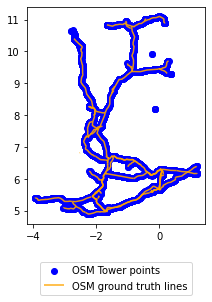

In [ ]:
fig = plt.figure(figsize=(12, 10))
ax = gh_twr_df.plot(color = 'blue', label = 'OSM Tower points')
gh_line_df.plot(ax = ax, color = 'orange', alpha = .9, label = 'OSM ground truth lines')
ax.legend(loc = 'center',bbox_to_anchor=(0.5, -0.25))

In [ ]:
gh_twr_df_final = cleanup_twr_df_DBSCAN(gh_twr_df, min_samples = 6) # can also change eps and min samples from default if needed
print("removed", len(gh_twr_df) -len(gh_twr_df_final), "outliar tower points" )
gh_twr_df_final.head()

removed 167 outliar tower points


,id,tags.power,tags.material,tags.height,tags.structure,tags.line_management,Type,Country,geometry,lon,lat
0,3.063476e+09,tower,None,None,None,None,Node,GH,POINT (-1.96697 6.67105),-1.966967,6.671052
1,3.063707e+09,tower,None,None,None,None,Node,GH,POINT (-2.11938 7.70032),-2.119378,7.700318
2,6.299353e+09,tower,None,None,None,None,Node,GH,POINT (-0.31116 6.17326),-0.311158,6.173257
3,3.063970e+09,tower,None,None,None,None,Node,GH,POINT (-2.34855 8.85587),-2.348553,8.855870
4,3.063970e+09,tower,None,None,None,None,Node,GH,POINT (-2.41069 8.92856),-2.410694,8.928565


<Figure size 864x720 with 0 Axes>

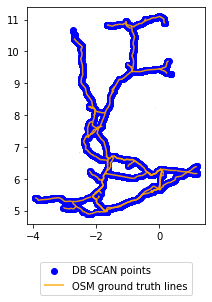

In [ ]:
fig = plt.figure(figsize=(12, 10))
ax = gh_twr_df_final.plot(color = 'blue', label = 'DB SCAN points')
#gh_twr_df.plot(ax = ax, color = 'yellow', alpha = .1, label = 'Original OSM points')
gh_line_df.plot(ax = ax, color = 'orange', alpha = .9, label = 'OSM ground truth lines')
ax.legend(loc = 'center',bbox_to_anchor=(0.5, -0.25))

#pixel based inference

use sl as less data points and smaller area

In [ ]:
dirs = ['sierra_leone']
country_dict = {'sierra_leone': 'SL'}
base_path = os.path.join('/content', 'drive', 'My Drive', 'PyPSA_Africa_images')
out_path = os.path.join(base_path, 'MAXAR_256')

for country in dirs:
    country_code = country_dict[country]
    max_ratio = 1.
    print(f"Making Examples for {country}!")

    # assess satellite imagery

    data_path = os.path.join(base_path, 'maxar', country, 'raw')

    #coverage_polygon = make_examples.make_polygon_list(data_path)
    towers_file = os.path.join(data_path, f"{country_code}_raw_towers.geojson")
    lines_file = os.path.join(data_path, f"{country_code}_raw_lines.geojson")

    sl_twr_df = gpd.read_file(towers_file)

    sl_line_df = gpd.read_file(lines_file)


Making Examples for sierra_leone!


In [ ]:
pixels = 512
gdf = sl_twr_df
gdf = gdf.to_crs("epsg:3857")
xmin, ymin, xmax, ymax= gdf.total_bounds
cell_size = pixel_2_m(pixels)
n_cells = np.rint((xmax-xmin)/cell_size)
n_cells

1262995.0

<Figure size 864x720 with 0 Axes>

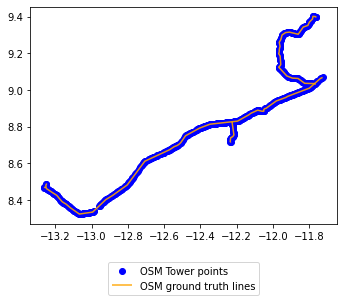

In [ ]:
fig = plt.figure(figsize=(12, 10))
ax = sl_twr_df.plot(color = 'blue', label = 'OSM Tower points')
sl_line_df.plot(ax = ax, color = 'orange', alpha = .9, label = 'OSM ground truth lines')
ax.legend(loc = 'center',bbox_to_anchor=(0.5, -0.25))

## test with subset area from DB scan cluster

In [ ]:
sl_twr_clusters = identify_outliers_DBSCAN(sl_twr_df,eps = 1.5e-2 ,min_samples = 5)

In [ ]:
sl_twr_clusters.value_counts()

 0    446
 1    114
 2     43
 3     28
 4     24
 5     18
 6      6
-1      6
 7      4
Name: cluster, dtype: int64

In [ ]:
df_cluster=pd.DataFrame(sl_twr_clusters)
ind_cluster_test=df_cluster.index[df_cluster['cluster']!= 7]

In [ ]:
df = sl_twr_df
for i in ind_cluster_test:
  clean_test_df = df.drop(ind_cluster_test)

<Figure size 864x720 with 0 Axes>

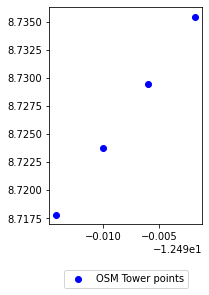

In [ ]:
fig = plt.figure(figsize=(12, 10))
ax = clean_test_df.plot(color = 'blue', label = 'OSM Tower points')
#sl_line_df.plot(ax = ax, color = 'orange', alpha = .9, label = 'OSM ground truth lines')
ax.legend(loc = 'center',bbox_to_anchor=(0.5, -0.25))

In [ ]:
fake_pix = 512*5

In [ ]:
fake_pix = 512
#pixels = 512
pixels = fake_pix
gdf = clean_test_df
gdf = gdf.to_crs("epsg:3857")
xmin, ymin, xmax, ymax= gdf.total_bounds
cell_size = pixel_2_m(pixels)
n_cells = np.rint((xmax-xmin)/cell_size)
n_cells

10283.0

In [ ]:
pixels = 512

twr_df = clean_test_df

network_guess_stoch_pix, thinned_network_guess_stoch_pix = network_inference_array_pixel(twr_df, pixels, random_start = False)


#lines_guess_gdf_pix = convert_guess_to_gdf_multilines_pixel(thinned_network_guess_stoch_pix, twr_df, pixels)

In [ ]:
lines_guess_gdf_pix = convert_guess_to_gdf_multilines_pixel(thinned_network_guess_stoch_pix, twr_df, pixels)

Text(0.5, 1.0, 'Ghana-1/10 resoution')

<Figure size 864x720 with 0 Axes>

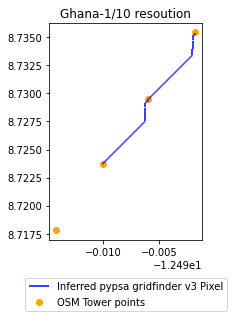

In [ ]:
fig = plt.figure(figsize=(12, 10))
ax = lines_guess_gdf_pix.plot(color = 'blue', label = 'Inferred pypsa gridfinder v3 Pixel')
clean_test_df.plot(ax = ax, color = 'orange', label = 'OSM Tower points')
ax.legend(loc = 'center',bbox_to_anchor=(0.5, -0.25) )
ax.set_title("Ghana-1/10 resoution")

# Average different instances for probability of false positive

rely on clustering at different levels and corresponding network guesses

##new function testing

###debug

iterate over list of thinner netowrk guess arrays

In [ ]:
#### 6 min samples #####
n_cells = 300
min_samples = 6
gh_twr_df_final = cleanup_twr_df_DBSCAN(gh_twr_df, min_samples = min_samples) # can also change eps and min samples from default if needed
print("removed", len(gh_twr_df) -len(gh_twr_df_final), "outliar tower points" , "with min samples of", min_samples)
gh_twr_df_final.head()

twr_df = gh_twr_df_final
network_guesses, thinned_network_guesses = network_inference_array_v4(twr_df, n_cells, random_start = True, multiple_starts= 5)


removed 167 outliar tower points with min samples of 6


__main__:21: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
__main__:21: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: +proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 + ...



'99.00 %'

'99.00 %'

'99.00 %'

'99.00 %'

'99.00 %'

In [ ]:
lines_guess_gdf_stoch6 = convert_guess_to_gdf_multilines3(thinned_network_guesses, twr_df, n_cells)

Text(0.5, 1.0, 'Ghana-300 cells')

<Figure size 864x720 with 0 Axes>

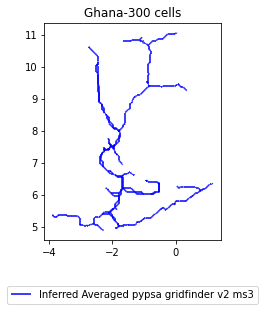

In [ ]:
lines_guess_gdf_stoch6 = convert_guess_to_gdf_multilines3(thinned_network_guesses, twr_df, n_cells)
fig = plt.figure(figsize=(12, 10))
ax = lines_guess_gdf_stoch6.plot(color = 'blue', label = 'Inferred Averaged pypsa gridfinder v2 ms3')
#gh_line_df.plot(ax = ax, color = 'orange', alpha = .5, label = 'OSM ground truth lines')
ax.legend(loc = 'center',bbox_to_anchor=(0.5, -0.25) )
ax.set_title("Ghana-300 cells")

Text(0.5, 1.0, 'Ghana-300 cells')

<Figure size 864x720 with 0 Axes>

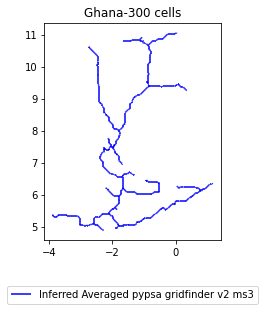

In [ ]:
lines_guess_gdf_stoch6 = convert_guess_to_gdf_multilines2(thinned_network_guesses[1], twr_df, n_cells)
fig = plt.figure(figsize=(12, 10))
ax = lines_guess_gdf_stoch6.plot(color = 'blue', label = 'Inferred Averaged pypsa gridfinder v2 ms3')
#gh_line_df.plot(ax = ax, color = 'orange', alpha = .5, label = 'OSM ground truth lines')
ax.legend(loc = 'center',bbox_to_anchor=(0.5, -0.25) )
ax.set_title("Ghana-300 cells")

In [ ]:
pts = np.argwhere(thinned_network_guess_stoch6==1)
print(len(pts))

768


In [ ]:
len(pts)

1623

In [ ]:
guess_skel = thin(network_guess_stoch6)

In [ ]:
thinned_network_guess_stoch6[1]

Text(0.5, 1.0, 'Ghana-300 cells')

<Figure size 864x720 with 0 Axes>

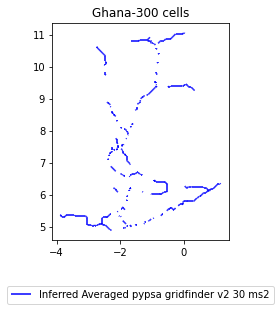

In [ ]:
lines_guess_gdf_stoch6 = convert_guess_to_gdf_multilines4(thinned_network_guess_stoch6, twr_df, n_cells, .5)
fig = plt.figure(figsize=(12, 10))
ax = lines_guess_gdf_stoch6.plot(color = 'blue', label = 'Inferred Averaged pypsa gridfinder v2 30 ms2')
#gh_line_df.plot(ax = ax, color = 'orange', alpha = .5, label = 'OSM ground truth lines')
ax.legend(loc = 'center',bbox_to_anchor=(0.5, -0.25) )
ax.set_title("Ghana-300 cells")

Text(0.5, 1.0, 'Ghana-300 cells')

<Figure size 864x720 with 0 Axes>

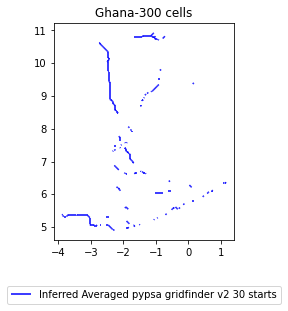

In [ ]:
fig = plt.figure(figsize=(12, 10))
ax = lines_guess_gdf_stoch6.plot(color = 'blue', label = 'Inferred Averaged pypsa gridfinder v2 30 starts')
#gh_line_df.plot(ax = ax, color = 'orange', alpha = .5, label = 'OSM ground truth lines')
ax.legend(loc = 'center',bbox_to_anchor=(0.5, -0.25) )
ax.set_title("Ghana-300 cells")

Text(0.5, 1.0, 'Ghana-300 cells')

<Figure size 864x720 with 0 Axes>

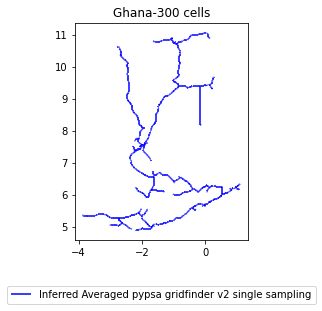

In [ ]:
fig = plt.figure(figsize=(12, 10))
ax = lines_guess_gdf_stoch2.plot(color = 'blue', label = 'Inferred Averaged pypsa gridfinder v2 single sampling')
#gh_line_df.plot(ax = ax, color = 'orange', alpha = .5, label = 'OSM ground truth lines')
ax.legend(loc = 'center',bbox_to_anchor=(0.5, -0.25) )
ax.set_title("Ghana-300 cells")

In [ ]:
fig = plt.figure(figsize=(12, 10))
ax = lines_guess_gdf_stoch6.plot(color = 'blue', label = 'Inferred Averaged pypsa gridfinder v2 3 starts')
gh_line_df.plot(ax = ax, color = 'orange', alpha = .5, label = 'OSM ground truth lines')
ax.legend(loc = 'center',bbox_to_anchor=(0.5, -0.25) )
ax.set_title("Ghana-300 cells")

In [ ]:
thinned_network_guess_stoch6

In [ ]:
network_guess_stoch6

In [ ]:
lines_guess_gdf_stoch6 = convert_guess_to_gdf_multilines2(thinned_network_guess_stoch5, twr_df, n_cells, treshold = .25)

In [ ]:
pts = np.argwhere(thinned_network_guess_stoch5>.1)
print(len(pts))

##working version best

### 300 cells 15 starts

In [ ]:
#### 6 min samples #####
n_cells = 300
min_samples = 6
gh_twr_df_final = cleanup_twr_df_DBSCAN(gh_twr_df, min_samples = min_samples) # can also change eps and min samples from default if needed
print("removed", len(gh_twr_df) -len(gh_twr_df_final), "outliar tower points" , "with min samples of", min_samples)
gh_twr_df_final.head()

twr_df = gh_twr_df_final
network_guess_stoch6, thinned_network_guess_stoch6= network_inference_array_v3(twr_df, n_cells, random_start = True, multiple_starts = 15)



removed 167 outliar tower points with min samples of 6


__main__:19: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
__main__:21: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: +proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 + ...



'99.00 %'

'99.00 %'

'99.00 %'

'99.00 %'

'99.00 %'

'99.00 %'

'99.00 %'

'99.00 %'

'99.00 %'

'99.00 %'

'99.00 %'

'99.00 %'

'99.00 %'

'99.00 %'

'99.00 %'

In [ ]:
multiple_starts = 15
prob_treshold = 6/multiple_starts # if at least 6 starting point initializations found a cell to be grid then enough to be included

Text(0.5, 1.0, 'Ghana-300 cells')

<Figure size 864x720 with 0 Axes>

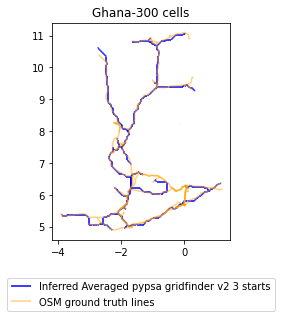

In [ ]:
lines_guess_gdf_stoch6 = convert_guess_to_gdf_multilines4(thinned_network_guess_stoch6, twr_df, n_cells, prob_treshold)
fig = plt.figure(figsize=(12, 10))
ax = lines_guess_gdf_stoch6.plot(color = 'blue', label = 'Inferred Averaged pypsa gridfinder v2 15 starts')
#gh_line_df.plot(ax = ax, color = 'orange', alpha = .5, label = 'OSM ground truth lines')
ax.legend(loc = 'center',bbox_to_anchor=(0.5, -0.25) )
ax.set_title("Ghana-300 cells")

Text(0.5, 1.0, 'Ghana-300 cells')

<Figure size 864x720 with 0 Axes>

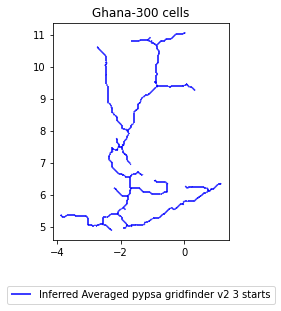

In [ ]:
multiple_starts = 15
prob_treshold = 7/multiple_starts # if at least 6 starting point initializations found a cell to be grid then enough to be included
lines_guess_gdf_stoch6 = convert_guess_to_gdf_multilines4(thinned_network_guess_stoch6, twr_df, n_cells, prob_treshold)
fig = plt.figure(figsize=(12, 10))
ax = lines_guess_gdf_stoch6.plot(color = 'blue', label = 'Inferred Averaged pypsa gridfinder v2 15 starts')
#gh_line_df.plot(ax = ax, color = 'orange', alpha = .5, label = 'OSM ground truth lines')
ax.legend(loc = 'center',bbox_to_anchor=(0.5, -0.25) )
ax.set_title("Ghana-300 cells")

### 300 cells 50 starts

In [ ]:
#### 6 min samples #####
n_cells = 300
min_samples = 6
multiple_starts = 50


twr_df = gh_twr_df_final
network_guess_stoch_50, thinned_network_guess_stoch_50= network_inference_array_v3(twr_df, n_cells, random_start = True, multiple_starts = multiple_starts)


__main__:19: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
__main__:21: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: +proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 + ...



'99.00 %'

'99.00 %'

'99.00 %'

'99.00 %'

'99.00 %'

'99.00 %'

'99.00 %'

'99.00 %'

'99.00 %'

'99.00 %'

'99.00 %'

'99.00 %'

'99.00 %'

'99.00 %'

'99.00 %'

'99.00 %'

'99.00 %'

'99.00 %'

'99.00 %'

'99.00 %'

'99.00 %'

'99.00 %'

'99.00 %'

'99.00 %'

'99.00 %'

'99.00 %'

'99.00 %'

'99.00 %'

'99.00 %'

'99.00 %'

'99.00 %'

'99.00 %'

'99.00 %'

'99.00 %'

'99.00 %'

'99.00 %'

'99.00 %'

'99.00 %'

'99.00 %'

'99.00 %'

'99.00 %'

'99.00 %'

'99.00 %'

'99.00 %'

'99.00 %'

'99.00 %'

'99.00 %'

'99.00 %'

'99.00 %'

'99.00 %'

Text(0.5, 1.0, 'Ghana-300 cells')

<Figure size 864x720 with 0 Axes>

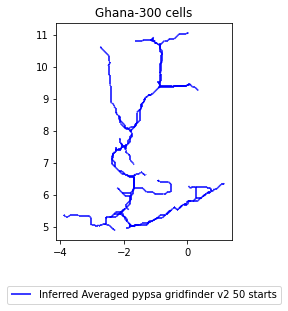

In [ ]:
multiple_starts = 50
prob_treshold = 1/multiple_starts # if at least 6 starting point initializations found a cell to be grid then enough to be included
lines_guess_gdf_stoch_50 = convert_guess_to_gdf_multilines4(thinned_network_guess_stoch_50, twr_df, n_cells, prob_treshold)
fig = plt.figure(figsize=(12, 10))
ax = lines_guess_gdf_stoch_50.plot(color = 'blue', label = 'Inferred Averaged pypsa gridfinder v2 50 starts')
#gh_line_df.plot(ax = ax, color = 'orange', alpha = .5, label = 'OSM ground truth lines')
ax.legend(loc = 'center',bbox_to_anchor=(0.5, -0.25) )
ax.set_title("Ghana-300 cells")

###1000 cells 5 starts

In [ ]:
#### 6 min samples #####
n_cells = 1000
min_samples = 6
multiple_starts = 3

twr_df = gh_twr_df_final
network_guess_stoch_1k_5, thinned_network_guess_stoch_1k_5= network_inference_array_v3(twr_df, n_cells, random_start = True, multiple_starts = multiple_starts)

__main__:19: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
__main__:21: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: +proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 + ...



'99.00 %'

'99.00 %'

'99.00 %'

In [ ]:
lines_guess_gdf_stoch_1k = convert_guess_to_gdf_multilines4(thinned_network_guess_stoch_1k_5, twr_df, n_cells, .1)

Text(0.5, 1.0, 'Ghana-1000 cells')

<Figure size 864x720 with 0 Axes>

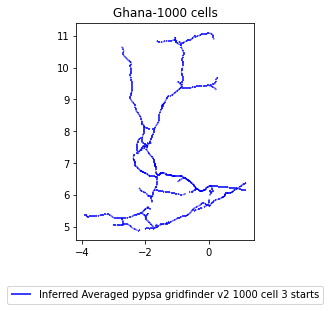

In [ ]:
#lines_guess_gdf_stoch_1k = convert_guess_to_gdf_multilines4(thinned_network_guess_stoch_1k_5, twr_df, n_cells, .1)
fig = plt.figure(figsize=(12, 10))
ax = lines_guess_gdf_stoch_1k.plot(color = 'blue', label = 'Inferred Averaged pypsa gridfinder v2 1000 cell 3 starts')
#gh_line_df.plot(ax = ax, color = 'orange', alpha = .5, label = 'OSM ground truth lines')
ax.legend(loc = 'center',bbox_to_anchor=(0.5, -0.25) )
ax.set_title("Ghana-1000 cells")

##2000 cells 2 starts

In [ ]:
#### 6 min samples #####
n_cells = 2000
min_samples = 6
multiple_starts = 2

twr_df = gh_twr_df_final
network_guess_stoch_2k_2, thinned_network_guess_stoch_2k_2= network_inference_array_v3(twr_df, n_cells, random_start = True, multiple_starts = multiple_starts)

__main__:19: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
__main__:21: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: +proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 + ...



'1.00 %'

TypeError: ignored

In [ ]:
lines_guess_gdf_stoch_2k = convert_guess_to_gdf_multilines4(thinned_network_guess_stoch_2k_2, twr_df, n_cells, .1)

In [ ]:
fig = plt.figure(figsize=(12, 10))
ax = lines_guess_gdf_stoch_2k.plot(color = 'blue', label = 'Inferred Averaged pypsa gridfinder v2 2000 cell 2 starts')
#gh_line_df.plot(ax = ax, color = 'orange', alpha = .5, label = 'OSM ground truth lines')
ax.legend(loc = 'center',bbox_to_anchor=(0.5, -0.25) )
ax.set_title("Ghana-2000 cells")

### 1000 cells 15 starts

In [ ]:
#### 6 min samples #####
n_cells = 1000
min_samples = 6
multiple_starts = 15

twr_df = gh_twr_df_final
network_guess_stoch_1k_15, thinned_network_guess_stoch_1k_15= network_inference_array_v3(twr_df, n_cells, random_start = True, multiple_starts = multiple_starts)

__main__:19: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
__main__:21: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: +proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 + ...



'99.00 %'

'99.00 %'

'99.00 %'

'99.00 %'

'99.00 %'

'99.00 %'

'99.00 %'

'99.00 %'

'99.00 %'

'99.00 %'

'99.00 %'

'99.00 %'

'99.00 %'

'99.00 %'

'99.00 %'

In [ ]:
target_list = np.argwhere(network_guess_stoch_1k_15 ==1.0)
len(target_list)

5281

In [ ]:
potential_lines = np.argwhere(network_guess_stoch_1k_15 >.01)
len(potential_lines)

7070

In [ ]:
gdf = twr_df
n_cells = 1000
cell = gdf_2_binary_gridded_conversion(gdf, n_cells)

#### obtain 2d numpy representation to run gridfinder algo
targets, costs = pts_df_to_2d_target_array(cell, n_cells)

__main__:3: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
__main__:21: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: +proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 + ...



In [ ]:
og_target_list = np.argwhere(targets ==1.0)
len(og_target_list)

3178

In [ ]:
len(twr_df)

11459

Text(0.5, 1.0, 'Ghana-1000 cells')

<Figure size 864x720 with 0 Axes>

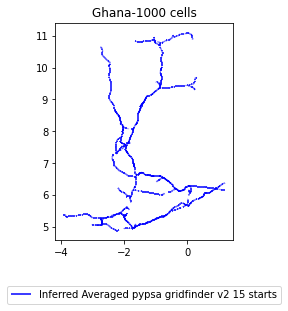

In [ ]:
#lines_guess_gdf_stoch_1k_15 = convert_guess_to_gdf_multilines4(thinned_network_guess_stoch_1k_15, twr_df, n_cells, .1)
fig = plt.figure(figsize=(12, 10))
ax = lines_guess_gdf_stoch_1k_15.plot(color = 'blue', label = 'Inferred Averaged pypsa gridfinder v2 15 starts')
#gh_line_df.plot(ax = ax, color = 'orange', alpha = .5, label = 'OSM ground truth lines')
ax.legend(loc = 'center',bbox_to_anchor=(0.5, -0.25) )
ax.set_title("Ghana-1000 cells")

Text(0.5, 1.0, 'Ghana-1000 cells')

<Figure size 864x720 with 0 Axes>

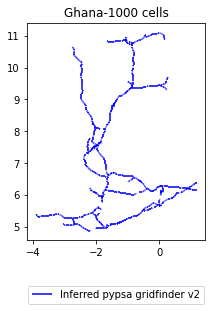

In [ ]:
# compare to output from single instance
fig = plt.figure(figsize=(12, 10))
ax = lines_guess_gdf_stoch.plot(color = 'blue', label = 'Inferred pypsa gridfinder v2')
#gh_line_df.plot(ax = ax, color = 'orange', alpha = .5, label = 'OSM ground truth lines')
ax.legend(loc = 'center',bbox_to_anchor=(0.5, -0.25) )
ax.set_title("Ghana-1000 cells")

Text(0.5, 1.0, 'Ghana-1000 cells')

<Figure size 864x720 with 0 Axes>

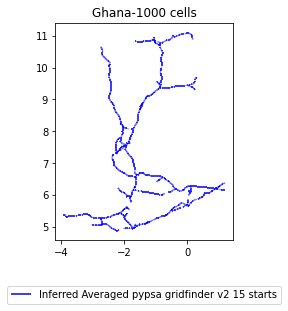

In [ ]:
lines_guess_gdf_stoch_1k_15 = convert_guess_to_gdf_multilines4(thinned_network_guess_stoch_1k_15, twr_df, n_cells, .5)
fig = plt.figure(figsize=(12, 10))
ax = lines_guess_gdf_stoch_1k_15.plot(color = 'blue', label = 'Inferred Averaged pypsa gridfinder v2 15 starts')
#gh_line_df.plot(ax = ax, color = 'orange', alpha = .5, label = 'OSM ground truth lines')
ax.legend(loc = 'center',bbox_to_anchor=(0.5, -0.25) )
ax.set_title("Ghana-1000 cells")

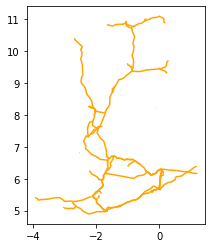

In [ ]:
gh_line_df.plot( color = 'orange',  label = 'OSM ground truth lines')

In [ ]:
fig = plt.figure(figsize=(12, 10))
ax = gh_line_df.plot(ax = ax, color = 'orange',  label = 'OSM ground truth lines')
#lines_guess_gdf_stoch_1k_15.plot(color = 'blue', label = 'Inferred Averaged pypsa gridfinder v2 15 starts')
#gh_line_df.plot(ax = ax, color = 'orange', alpha = .5, label = 'OSM ground truth lines')
ax.legend(loc = 'center',bbox_to_anchor=(0.5, -0.25) )
ax.set_title("Ghana-1000 cells")

Text(0.5, 1.0, 'Ghana-1000 cells')

<Figure size 864x720 with 0 Axes>

#### 1000 cells 2 starts

In [ ]:
#### 6 min samples #####
n_cells = 1000
min_samples = 6
multiple_starts = 2

twr_df = gh_twr_df_final
network_guess_stoch_1k_2, thinned_network_guess_stoch_1k_2= network_inference_array_v3(twr_df, n_cells, random_start = True, multiple_starts = multiple_starts)

__main__:19: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
__main__:21: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: +proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 + ...



'99.00 %'

'99.00 %'

Text(0.5, 1.0, 'Ghana-1000 cells')

<Figure size 864x720 with 0 Axes>

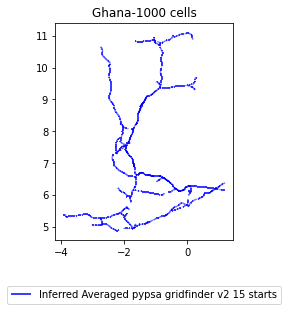

In [ ]:
lines_guess_gdf_stoch_1k_2 = convert_guess_to_gdf_multilines4(thinned_network_guess_stoch_1k_2, twr_df, n_cells, .1)
fig = plt.figure(figsize=(12, 10))
ax = lines_guess_gdf_stoch_1k_2.plot(color = 'blue', label = 'Inferred Averaged pypsa gridfinder v2 15 starts')
#gh_line_df.plot(ax = ax, color = 'orange', alpha = .5, label = 'OSM ground truth lines')
ax.legend(loc = 'center',bbox_to_anchor=(0.5, -0.25) )
ax.set_title("Ghana-1000 cells")

Text(0.5, 1.0, 'Ghana-2000 cells')

<Figure size 864x720 with 0 Axes>

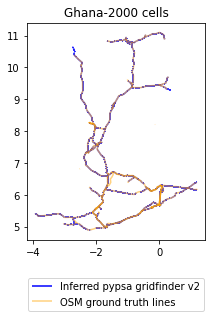

In [ ]:
fig = plt.figure(figsize=(12, 10))
ax = lines_guess_gdf_stoch_2k.plot(color = 'blue', label = 'Inferred pypsa gridfinder v2')
gh_line_df.plot(ax = ax, color = 'orange', alpha = .5, label = 'OSM ground truth lines')
ax.legend(loc = 'center',bbox_to_anchor=(0.5, -0.25) )
ax.set_title("Ghana-2000 cells")

## now build function to check whether tower point is true or false positive

retrieve indexes of outliers like below to then compare points that are both not included in grid but were original tower points as corresponding to their grid index

In [ ]:
tower_point =
power_point_idx=

In [ ]:
#### 2 min samples #####
n_cells = 300
min_samples = 2
gh_twr_df_final = cleanup_twr_df_DBSCAN(gh_twr_df, min_samples = min_samples) # can also change eps and min samples from default if needed
print("removed", len(gh_twr_df) -len(gh_twr_df_final), "outliar tower points" , "with min samples of", min_samples)
gh_twr_df_final.head()

twr_df = gh_twr_df_final
network_guess_stoch2, thinned_network_guess_stoch2, targets2= network_inference_array_v3_old(twr_df, n_cells, random_start = True)


lines_guess_gdf_stoch2 = convert_guess_to_gdf_multilines(thinned_network_guess_stoch2, twr_df, n_cells)

removed 15 outliar tower points with min samples of 2


__main__:19: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
__main__:21: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: +proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 + ...



'99.00 %'

In [ ]:
#### 2 min samples #####
n_cells = 500
twr_df = gh_twr_df
network_guess_stoch2, thinned_network_guess_stoch2, targets2= network_inference_array_v3(twr_df, n_cells, random_start = True)


lines_guess_gdf_stoch2 = convert_guess_to_gdf_multilines(thinned_network_guess_stoch2, twr_df, n_cells)

__main__:19: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
__main__:21: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: +proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 + ...



'99.00 %'

Text(0.5, 1.0, 'Ghana-300 cells')

<Figure size 864x720 with 0 Axes>

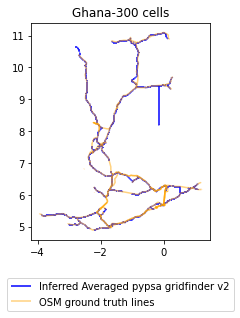

In [ ]:

fig = plt.figure(figsize=(12, 10))
ax = lines_guess_gdf_stoch2.plot(color = 'blue', label = 'Inferred Averaged pypsa gridfinder v2')
gh_line_df.plot(ax = ax, color = 'orange', alpha = .5, label = 'OSM ground truth lines')
ax.legend(loc = 'center',bbox_to_anchor=(0.5, -0.25) )
ax.set_title("Ghana-300 cells")

In [ ]:
target_list = np.argwhere(targets6 ==1.0)
len(target_list)

202

In [ ]:
target_list = np.argwhere(network_guess_stoch6 ==1.0)
len(target_list)

1331

In [ ]:
inf_diff = np.abs(network_guess_stoch6-targets6)

In [ ]:
inf_diff

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
potential_outliars = np.argwhere(inf_diff>.1)

In [ ]:
len(potential_outliars)

1129

llok for outliars by differences in input targets and network guess

In [ ]:
avg_network_guess= (thinned_network_guess_stoch4 + thinned_network_guess_stoch6 )/2

In [ ]:
avg_network_guess

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
avg_guess = np.mean([thinned_network_guess_stoch4, thinned_network_guess_stoch6], axis = 0)

In [ ]:
avg_guess

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
inf_diff_list = np.argwhere(np.not_equal(avg_network_guess, avg_guess))

In [ ]:
inf_diff_list

array([], shape=(0, 2), dtype=int64)

In [ ]:
inf_diff = np.not_equal(network_guess_stoch2, targets2)

In [ ]:
np.unique(inf_diff, return_counts= True)

(array([False,  True]), array([299996,   2004]))

In [ ]:
len(inf_diff)

604

In [ ]:
n_cells = 300

#### 2 min samples #####
min_samples = 2
gh_twr_df_final = cleanup_twr_df_DBSCAN(gh_twr_df, min_samples = min_samples) # can also change eps and min samples from default if needed
print("removed", len(gh_twr_df) -len(gh_twr_df_final), "outliar tower points" , "with min samples of", min_samples)
gh_twr_df_final.head()

twr_df = gh_twr_df_final
network_guess_stoch2, thinned_network_guess_stoch2 = network_inference_array_v2(twr_df, n_cells, random_start = True)


lines_guess_gdf_stoch2 = convert_guess_to_gdf_multilines(thinned_network_guess_stoch2, twr_df, n_cells)


#### 4 min samples #####
min_samples = 4
gh_twr_df_final = cleanup_twr_df_DBSCAN(gh_twr_df, min_samples = min_samples) # can also change eps and min samples from default if needed
print("removed", len(gh_twr_df) -len(gh_twr_df_final), "outliar tower points" , "with min samples of", min_samples)
gh_twr_df_final.head()

twr_df = gh_twr_df_final
network_guess_stoch4, thinned_network_guess_stoch4 = network_inference_array_v2(twr_df, n_cells, random_start = True)


lines_guess_gdf_stoch4 = convert_guess_to_gdf_multilines(thinned_network_guess_stoch4, twr_df, n_cells)


#### 6 min samples #####
min_samples = 6
gh_twr_df_final = cleanup_twr_df_DBSCAN(gh_twr_df, min_samples = min_samples) # can also change eps and min samples from default if needed
print("removed", len(gh_twr_df) -len(gh_twr_df_final), "outliar tower points" , "with min samples of", min_samples)
gh_twr_df_final.head()

twr_df = gh_twr_df_final
network_guess_stoch6, thinned_network_guess_stoch6 = network_inference_array_v2(twr_df, n_cells, random_start = True)


lines_guess_gdf_stoch6 = convert_guess_to_gdf_multilines(thinned_network_guess_stoch6, twr_df, n_cells)


#### 5 min samples #####
min_samples = 5
gh_twr_df_final = cleanup_twr_df_DBSCAN(gh_twr_df, min_samples = min_samples) # can also change eps and min samples from default if needed
print("removed", len(gh_twr_df) -len(gh_twr_df_final), "outliar tower points" , "with min samples of", min_samples)
gh_twr_df_final.head()

twr_df = gh_twr_df_final
network_guess_stoch5, thinned_network_guess_stoch5 = network_inference_array_v2(twr_df, n_cells, random_start = True)


lines_guess_gdf_stoch5 = convert_guess_to_gdf_multilines(thinned_network_guess_stoch5, twr_df, n_cells)






In [ ]:
avg_network_guess= (thinned_network_guess_stoch2 + thinned_network_guess_stoch4 + thinned_network_guess_stoch6 + thinned_network_guess_stoch5)/4

In [ ]:
avg_network_guess= (thinned_network_guess_stoch2 + thinned_network_guess_stoch4 )/2

In [ ]:
target_list = np.argwhere(avg_network_guess == 1.0)

In [ ]:
target_list = np.argwhere(avg_network_guess >.25)

In [ ]:
target_list

In [ ]:
len(target_list)

1360

In [ ]:
avg_network_guess

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
stats.describe(thinned_network_guess_stoch6)

In [ ]:
from scipy import stats
stats.describe(avg_network_guess)

In [ ]:
lines_guess_gdf_avg = convert_guess_to_gdf_multilines2(avg_network_guess, gh_twr_df, n_cells, treshold = .25)

Text(0.5, 1.0, 'Ghana-300 cells')

<Figure size 864x720 with 0 Axes>

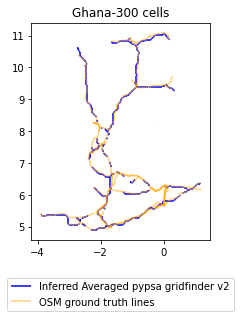

In [ ]:
fig = plt.figure(figsize=(12, 10))
ax = lines_guess_gdf_avg.plot(color = 'blue', label = 'Inferred Averaged pypsa gridfinder v2')
gh_line_df.plot(ax = ax, color = 'orange', alpha = .5, label = 'OSM ground truth lines')
ax.legend(loc = 'center',bbox_to_anchor=(0.5, -0.25) )
ax.set_title("Ghana-300 cells")

Text(0.5, 1.0, 'Ghana-300 cells')

<Figure size 864x720 with 0 Axes>

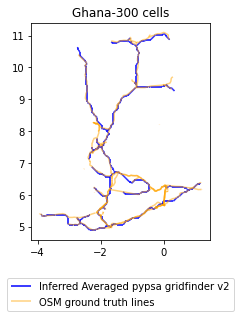

In [ ]:
fig = plt.figure(figsize=(12, 10))
ax = lines_guess_gdf_stoch2.plot(color = 'blue', label = 'Inferred Averaged pypsa gridfinder v2')
gh_line_df.plot(ax = ax, color = 'orange', alpha = .5, label = 'OSM ground truth lines')
ax.legend(loc = 'center',bbox_to_anchor=(0.5, -0.25) )
ax.set_title("Ghana-300 cells")

Text(0.5, 1.0, 'Ghana-300 cells')

<Figure size 864x720 with 0 Axes>

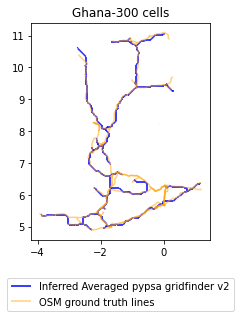

In [ ]:
fig = plt.figure(figsize=(12, 10))
ax = lines_guess_gdf_stoch6.plot(color = 'blue', label = 'Inferred Averaged pypsa gridfinder v2')
gh_line_df.plot(ax = ax, color = 'orange', alpha = .5, label = 'OSM ground truth lines')
ax.legend(loc = 'center',bbox_to_anchor=(0.5, -0.25) )
ax.set_title("Ghana-300 cells")

DB scan based outliar detection through distance of each tower point from inferred grid

##300 cells

In [ ]:
n_cells = 300
twr_df = gh_twr_df

network_guess_stoch, thinned_network_guess_stoch = network_inference_array_v2(twr_df, n_cells, random_start = True)


lines_guess_gdf_stoch = convert_guess_to_gdf_multilines(thinned_network_guess_stoch, twr_df, n_cells)

__main__:19: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
__main__:21: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: +proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 + ...



'99.00 %'

Text(0.5, 1.0, 'Ghana-300 cells')

<Figure size 864x720 with 0 Axes>

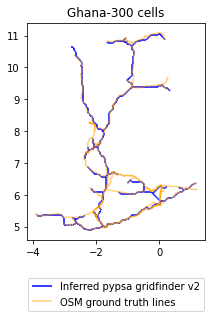

In [ ]:
fig = plt.figure(figsize=(12, 10))
ax = lines_guess_gdf_stoch.plot(color = 'blue', label = 'Inferred pypsa gridfinder v2')
gh_line_df.plot(ax = ax, color = 'orange', alpha = .5, label = 'OSM ground truth lines')
ax.legend(loc = 'center',bbox_to_anchor=(0.5, -0.25) )
ax.set_title("Ghana-300 cells")

In [ ]:
true_pos, false_neg = inference_accuracy(lines_guess_gdf_stoch, gh_line_df, n_cells)

print(f'Points identified as grid that are grid: {100*true_pos:.0f}%')
print(f'Actual grid that was missed: {100*false_neg:.0f}%')

##500 cells

In [ ]:
n_cells = 500
twr_df = gh_twr_df

network_guess_stoch, thinned_network_guess_stoch = network_inference_array_v2(twr_df, n_cells, random_start = True)


lines_guess_gdf_stoch = convert_guess_to_gdf_multilines(thinned_network_guess_stoch, twr_df, n_cells)

__main__:19: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
__main__:21: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: +proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 + ...



'99.00 %'

Text(0.5, 1.0, 'Ghana-500 cells')

<Figure size 864x720 with 0 Axes>

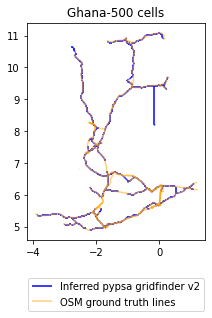

In [ ]:
fig = plt.figure(figsize=(12, 10))
ax = lines_guess_gdf_stoch.plot(color = 'blue', label = 'Inferred pypsa gridfinder v2')
gh_line_df.plot(ax = ax, color = 'orange', alpha = .5, label = 'OSM ground truth lines')
ax.legend(loc = 'center',bbox_to_anchor=(0.5, -0.25) )
ax.set_title("Ghana-500 cells")

In [ ]:
true_pos, false_neg = inference_accuracy(lines_guess_gdf_stoch, gh_line_df, n_cells)

print(f'Points identified as grid that are grid: {100*true_pos:.0f}%')
print(f'Actual grid that was missed: {100*false_neg:.0f}%')

##2000 cells

In [ ]:
n_cells = 2000
twr_df = gh_twr_df_final

network_guess_stoch_2k, thinned_network_guess_stoch_2k = network_inference_array_v2(twr_df, n_cells, random_start = True)


lines_guess_gdf_stoch_2k = convert_guess_to_gdf_multilines(thinned_network_guess_stoch_2k, twr_df, n_cells)

__main__:19: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
__main__:21: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: +proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 + ...



'99.00 %'

Text(0.5, 1.0, 'Ghana-2000 cells')

<Figure size 864x720 with 0 Axes>

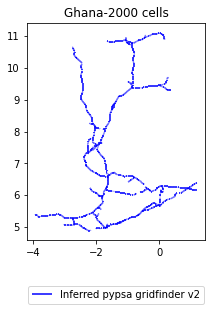

In [ ]:
fig = plt.figure(figsize=(12, 10))
ax = lines_guess_gdf_stoch_2k.plot(color = 'blue', label = 'Inferred pypsa gridfinder v2')
#gh_line_df.plot(ax = ax, color = 'orange', alpha = .5, label = 'OSM ground truth lines')
ax.legend(loc = 'center',bbox_to_anchor=(0.5, -0.25) )
ax.set_title("Ghana-2000 cells")

##1000 cells

In [ ]:
n_cells = 1000
twr_df = gh_twr_df_final

network_guess_stoch, thinned_network_guess_stoch = network_inference_array_v2(twr_df, n_cells, random_start = True)


lines_guess_gdf_stoch = convert_guess_to_gdf_multilines(thinned_network_guess_stoch, twr_df, n_cells)

__main__:19: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
__main__:21: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: +proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 + ...



'99.00 %'

Text(0.5, 1.0, 'Ghana-1000 cells')

<Figure size 864x720 with 0 Axes>

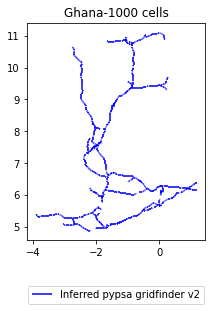

In [ ]:
fig = plt.figure(figsize=(12, 10))
ax = lines_guess_gdf_stoch.plot(color = 'blue', label = 'Inferred pypsa gridfinder v2')
#gh_line_df.plot(ax = ax, color = 'orange', alpha = .5, label = 'OSM ground truth lines')
ax.legend(loc = 'center',bbox_to_anchor=(0.5, -0.25) )
ax.set_title("Ghana-1000 cells")

#### new outliar detection dbscan

512 by 512 is the resolution of gridded representation from detectron and lukas

build function to convert this into ncell sautomatically

In [ ]:
clean_gh_twr_pts = remove_detected_outliers_DBSCAN_v2(gh_twr_df,lines_guess_gdf_stoch)
clean_gh_twr_pts.head()

__main__:14: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

__main__:15: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



,id,tags.power,tags.material,tags.height,tags.structure,tags.line_management,Type,Country,geometry,lon,lat
0,3.063476e+09,tower,None,None,None,None,Node,GH,POINT (-1.96697 6.67105),-1.966967,6.671052
1,3.063707e+09,tower,None,None,None,None,Node,GH,POINT (-2.11938 7.70032),-2.119378,7.700318
2,6.299353e+09,tower,None,None,None,None,Node,GH,POINT (-0.31116 6.17326),-0.311158,6.173257
3,3.063970e+09,tower,None,None,None,None,Node,GH,POINT (-2.34855 8.85587),-2.348553,8.855870
4,3.063970e+09,tower,None,None,None,None,Node,GH,POINT (-2.41069 8.92856),-2.410694,8.928565


<Figure size 864x720 with 0 Axes>

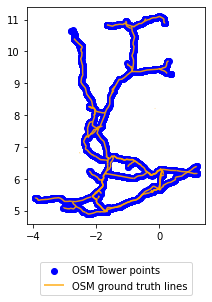

In [ ]:
fig = plt.figure(figsize=(12, 10))
ax = clean_gh_twr_pts.plot(color = 'blue', label = 'OSM Tower points')
gh_line_df.plot(ax = ax, color = 'orange', alpha = .9, label = 'OSM ground truth lines')
ax.legend(loc = 'center',bbox_to_anchor=(0.5, -0.25))

In [ ]:
eps = 1.5e-2
min_samples = 4

#gh_twr_df = df
gh_twr_df['lon'] = gh_twr_df.geometry.apply(lambda p: p.x)
gh_twr_df['lat'] = gh_twr_df.geometry.apply(lambda p: p.y)

# represent points consistently as (lat, lon)
pts_coords_df = gh_twr_df[['lat', 'lon']]

# now same for lines
lines_guess_gdf_stoch['lon'] = lines_guess_gdf_stoch.geometry.centroid.apply(lambda p: p.x)
lines_guess_gdf_stoch['lat'] = lines_guess_gdf_stoch.geometry.centroid.apply(lambda p: p.y)

lines_coords_df = lines_guess_gdf_stoch[['lat', 'lon']]

db_scan_model = DBSCAN(eps = eps, min_samples = min_samples)

outlier_detection = db_scan_model.fit(lines_coords_df)

clusters_pts = outlier_detection.fit_predict(pts_coords_df)

data = pd.DataFrame()
data['cluster'] = clusters_pts
df_cluster=pd.DataFrame(data['cluster'])
ind_outlier=df_cluster.index[df_cluster['cluster']==-1]
ind_outlier


df = gh_twr_df
for i in ind_outlier:
  clean_df = df.drop(ind_outlier)



__main__:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

__main__:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



In [ ]:
gh_twr_df['lon']

In [ ]:
outlier_detection = db_scan_model.fit(lines_coords_df)

In [ ]:
clusters_pts = outlier_detection.fit_predict(pts_coords_df)

In [ ]:
#clusters_pts = db_scan_model.fit_predict(lines_coords_df)
data = pd.DataFrame()
data['cluster'] = clusters_pts
df_cluster=pd.DataFrame(data['cluster'])
ind_outlier=df_cluster.index[df_cluster['cluster']==-1]
ind_outlier


Int64Index([  151,   211,   372,   493,   629,   873,   927,  1156,  1460,
             1502,  1921,  2160,  2322,  2370,  2505,  2515,  2619,  2941,
             2987,  3308,  3320,  3483,  4571,  4655,  4744,  5136,  5163,
             5499,  5533,  6207,  6381,  6422,  6542,  6599,  6705,  6913,
             7068,  7228,  7501,  7708,  8164,  8415,  9463,  9721,  9795,
             9822,  9848, 10208, 10453, 10726, 10915, 11007, 11494, 11518,
            11522],
           dtype='int64')

In [ ]:
df = gh_twr_df
for i in ind_outlier:
  df_final = df.drop(ind_outlier)

In [ ]:
len(gh_twr_df)

11626

In [ ]:
len(df_final)

11571

In [ ]:
outliar_df = df_cluster[df_cluster['cluster']==-1]

In [ ]:
outliar_df.head()

,cluster
151,-1
211,-1
372,-1
493,-1
629,-1


In [ ]:
len(outliar_df)

55

In [ ]:
df_cluster.index[ind_outlier]

Int64Index([  151,   211,   372,   493,   629,   873,   927,  1156,  1460,
             1502,  1921,  2160,  2322,  2370,  2505,  2515,  2619,  2941,
             2987,  3308,  3320,  3483,  4571,  4655,  4744,  5136,  5163,
             5499,  5533,  6207,  6381,  6422,  6542,  6599,  6705,  6913,
             7068,  7228,  7501,  7708,  8164,  8415,  9463,  9721,  9795,
             9822,  9848, 10208, 10453, 10726, 10915, 11007, 11494, 11518,
            11522],
           dtype='int64')

In [ ]:
len(ind_outlier)

55

In [ ]:
len(ind_outlier)

15

In [ ]:
def dbscan_predict(model, X):

    nr_samples = X.shape[0]

    y_new = np.ones(shape=nr_samples, dtype=int) * -1

    for i in range(nr_samples):
        diff = model.components_ - X[i, :]  # NumPy broadcasting

        dist = np.linalg.norm(diff, axis=1)  # Euclidean distance

        shortest_dist_idx = np.argmin(dist)

        if dist[shortest_dist_idx] < model.eps:
            y_new[i] = model.labels_[model.core_sample_indices_[shortest_dist_idx]]

    return y_new

In [ ]:
clusters_pts = db_scan_model.fit_predict(pts_coords_df)

In [ ]:
clusters_pts = outlier_detection.fit_predict(pts_coords_df)
clusters_lines = outlier_detection.fit_predict(lines_coords_df)
#clusters_pts = outlier_detection.fit_predict(pts_coords_df)

In [ ]:
clusters_lines

array([-1])

In [ ]:
data = pd.DataFrame()
data['cluster'] = clusters_pts

In [ ]:
df_cluster=pd.DataFrame(data['cluster'])


In [ ]:
ind_outlier=df_cluster.index[df_cluster['cluster']==-1]

In [ ]:
ind_outlier

Int64Index([  109,   151,   198,   211,   218,   236,   337,   372,   421,
              425,
            ...
            10915, 11007, 11016, 11132, 11320, 11347, 11494, 11518, 11522,
            11570],
           dtype='int64', length=167)

In [ ]:
clusters_pts

array([ 0,  1,  2, ...,  4,  0, 20])

# Other countried validation

## Sierra Leone

##data loading/cleanup

In [ ]:
dirs = ['sierra_leone']
country_dict = {'sierra_leone': 'SL'}
base_path = os.path.join('/content', 'drive', 'My Drive', 'PyPSA_Africa_images')
out_path = os.path.join(base_path, 'MAXAR_256')

for country in dirs:
    country_code = country_dict[country]
    max_ratio = 1.
    print(f"Making Examples for {country}!")

    # assess satellite imagery

    data_path = os.path.join(base_path, 'maxar', country, 'raw')

    #coverage_polygon = make_examples.make_polygon_list(data_path)
    towers_file = os.path.join(data_path, f"{country_code}_raw_towers.geojson")
    lines_file = os.path.join(data_path, f"{country_code}_raw_lines.geojson")

    sl_twr_df = gpd.read_file(towers_file)

    sl_line_df = gpd.read_file(lines_file)


Making Examples for sierra_leone!


<Figure size 864x720 with 0 Axes>

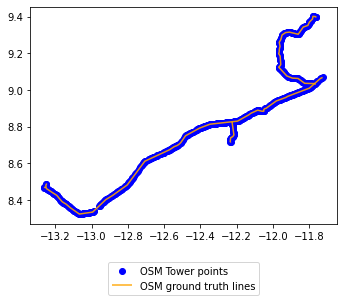

In [ ]:
fig = plt.figure(figsize=(12, 10))
ax = sl_twr_df.plot(color = 'blue', label = 'OSM Tower points')
sl_line_df.plot(ax = ax, color = 'orange', alpha = .9, label = 'OSM ground truth lines')
ax.legend(loc = 'center',bbox_to_anchor=(0.5, -0.25))

In [ ]:
sl_twr_df_final = cleanup_twr_df_DBSCAN(sl_twr_df) # can also change eps and min samples
print("removed", len(sl_twr_df) -len(sl_twr_df_final), "outliar tower points" )
sl_twr_df_final.head()

removed 12 outliar tower points


,id,tags.power,Type,Country,geometry,lon,lat
0,8.668409e+09,tower,Node,sierra-leone,POINT (-12.23362 8.72763),-12.233624,8.727629
1,7.865532e+09,tower,Node,sierra-leone,POINT (-11.96353 9.22329),-11.963526,9.223285
2,7.657401e+09,tower,Node,sierra-leone,POINT (-11.87246 9.06342),-11.872457,9.063423
3,2.178168e+09,tower,Node,sierra-leone,POINT (-12.30218 8.81809),-12.302185,8.818093
4,2.179081e+09,tower,Node,sierra-leone,POINT (-11.95588 8.94883),-11.955880,8.948829


<Figure size 864x720 with 0 Axes>

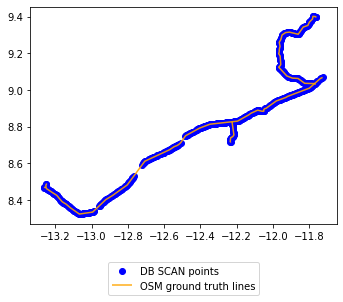

In [ ]:
fig = plt.figure(figsize=(12, 10))
ax = sl_twr_df_final.plot(color = 'blue', label = 'DB SCAN points')
#gh_twr_df.plot(ax = ax, color = 'yellow', alpha = .1, label = 'Original OSM points')
sl_line_df.plot(ax = ax, color = 'orange', alpha = .9, label = 'OSM ground truth lines')
ax.legend(loc = 'center',bbox_to_anchor=(0.5, -0.25))

##300 cells

In [ ]:
n_cells = 300
twr_df = sl_twr_df_final

network_guess_stoch, thinned_network_guess_stoch = network_inference_array_v2(twr_df, n_cells, random_start = True)


lines_guess_gdf_stoch = convert_guess_to_gdf_multilines(thinned_network_guess_stoch, twr_df, n_cells)


__main__:19: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
__main__:21: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: +proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 + ...



'99.00 %'

Text(0.5, 1.0, 'Sierra Leone Grid 300 cells')

<Figure size 864x720 with 0 Axes>

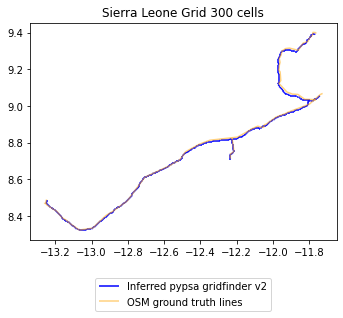

In [ ]:
fig = plt.figure(figsize=(12, 10))
ax = lines_guess_gdf_stoch.plot(color = 'blue', label = 'Inferred pypsa gridfinder v2')
sl_line_df.plot(ax = ax, color = 'orange', alpha = .5, label = 'OSM ground truth lines')
ax.legend(loc = 'center',bbox_to_anchor=(0.5, -0.25) )
ax.set_title("Sierra Leone Grid 300 cells")

In [ ]:
true_pos, false_neg = inference_accuracy(lines_guess_gdf_stoch, sl_line_df, n_cells)

print(f'Points identified as grid that are grid: {100*true_pos:.0f}%')
print(f'Actual grid that was missed: {100*false_neg:.0f}%')

##malawi

##data loading

In [ ]:
dirs = ['malawi']
country_dict = {'malawi': 'MW'}
base_path = os.path.join('/content', 'drive', 'My Drive', 'PyPSA_Africa_images')
out_path = os.path.join(base_path, 'MAXAR_256')

for country in dirs:
    country_code = country_dict[country]
    max_ratio = 1.
    print(f"Making Examples for {country}!")

    # assess satellite imagery

    data_path = os.path.join(base_path, 'maxar', country, 'raw')

    #coverage_polygon = make_examples.make_polygon_list(data_path)
    towers_file = os.path.join(data_path, f"{country_code}_raw_towers.geojson")
    lines_file = os.path.join(data_path, f"{country_code}_raw_lines.geojson")

    mw_twr_df = gpd.read_file(towers_file)

    mw_line_df = gpd.read_file(lines_file)


Making Examples for malawi!


In [ ]:
mw_twr_df_final = cleanup_twr_df_DBSCAN(mw_twr_df, eps = 1.5e-2, min_samples=10) # can also change eps and min samples
print("removed", len(mw_twr_df) -len(mw_twr_df_final), "outliar tower points" )
mw_twr_df_final.head()

removed 259 outliar tower points


,id,tags.power,tags.material,tags.structure,tags.operator,Type,Country,geometry,lon,lat
0,6.242317e+09,tower,None,None,None,Node,MW,POINT (34.09472 -11.95654),34.094721,-11.956544
1,6.242317e+09,tower,None,None,None,Node,MW,POINT (34.12342 -12.53029),34.123421,-12.530292
2,6.253643e+09,tower,wood,None,None,Node,MW,POINT (34.87311 -15.17108),34.873110,-15.171082
3,5.309298e+09,tower,None,None,None,Node,MW,POINT (34.01759 -13.99351),34.017588,-13.993508
4,6.250055e+09,tower,wood,None,None,Node,MW,POINT (33.93620 -10.96230),33.936198,-10.962305


##300 cells

In [ ]:
n_cells = 300
twr_df = mw_twr_df
network_guess_stoch, thinned_network_guess_stoch = network_inference_array_v2(twr_df, n_cells, random_start = True)


lines_guess_gdf_stoch = convert_guess_to_gdf_multilines(thinned_network_guess_stoch, twr_df, n_cells)

__main__:19: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
__main__:21: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: +proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 + ...



'99.00 %'

Text(0.5, 1.0, 'Malawi Grid 300 cells')

<Figure size 864x720 with 0 Axes>

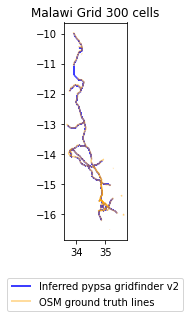

In [ ]:
fig = plt.figure(figsize=(12, 10))
ax = lines_guess_gdf_stoch.plot(color = 'blue', label = 'Inferred pypsa gridfinder v2')
mw_line_df.plot(ax = ax, color = 'orange', alpha = .5, label = 'OSM ground truth lines')
ax.legend(loc = 'center',bbox_to_anchor=(0.5, -0.25) )
ax.set_title("Malawi Grid 300 cells")

In [ ]:
true_pos, false_neg = inference_accuracy(lines_guess_gdf_stoch, mw_line_df, n_cells)

print(f'Points identified as grid that are grid: {100*true_pos:.0f}%')
print(f'Actual grid that was missed: {100*false_neg:.0f}%')

##500 cells

In [ ]:
n_cells = 500

network_guess, thinned_network_guess = network_inference_array(mw_twr_df, n_cells )


lines_guess_gdf_mw = convert_guess_to_gdf_multilines(thinned_network_guess, mw_twr_df, n_cells)


true_pos, false_neg = inference_accuracy(lines_guess_gdf_mw, mw_line_df, n_cells)

print(f'Points identified as grid that are grid: {100*true_pos:.0f}%')
print(f'Actual grid that was missed: {100*false_neg:.0f}%')

fig = plt.figure(figsize=(12, 10))
ax = lines_guess_gdf_mw.plot(color = 'blue', label = 'Inferred pypsa gridfinder')
mw_line_df.plot(ax = ax, color = 'orange', alpha = .5, label = 'OSM ground truth lines')
ax.legend(loc = 'center',bbox_to_anchor=(0.5, -0.25) )

Text(0.5, 1.0, 'Malawi Grid 500 cells')

<Figure size 864x720 with 0 Axes>

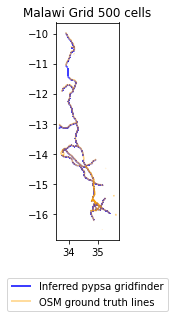

In [ ]:
fig = plt.figure(figsize=(12, 10))
ax = lines_guess_gdf_mw.plot(color = 'blue', label = 'Inferred pypsa gridfinder')
mw_line_df.plot(ax = ax, color = 'orange', alpha = .5, label = 'OSM ground truth lines')
ax.legend(loc = 'center',bbox_to_anchor=(0.5, -0.25) )
ax.set_title("Malawi Grid 500 cells")

##Nigeria

##data loading

In [ ]:
dirs = ['nigeria']
country_dict = {'nigeria': 'NG'}
base_path = os.path.join('/content', 'drive', 'My Drive', 'PyPSA_Africa_images')
out_path = os.path.join(base_path, 'MAXAR_256')

for country in dirs:
    country_code = country_dict[country]
    max_ratio = 1.
    print(f"Making Examples for {country}!")

    # assess satellite imagery

    data_path = os.path.join(base_path, 'raw_towers_and_lines')

    #coverage_polygon = make_examples.make_polygon_list(data_path)
    towers_file = os.path.join(data_path, f"{country_code}_raw_towers.geojson")
    lines_file = os.path.join(data_path, f"{country_code}_raw_lines.geojson")

    ng_twr_df = gpd.read_file(towers_file)

    ng_line_df = gpd.read_file(lines_file)


Making Examples for nigeria!


In [ ]:
fig = plt.figure(figsize=(12, 10))
ax = ng_twr_df.plot(color = 'blue', label = 'OSM Tower points')
ng_line_df.plot(ax = ax, color = 'orange', alpha = .9, label = 'OSM ground truth lines')
ax.legend(loc = 'center',bbox_to_anchor=(0.5, -0.25))

In [ ]:
ng_twr_df_final = cleanup_twr_df_DBSCAN(ng_twr_df) # can also change eps and min samples from default if needed
print("removed", len(ng_twr_df) -len(ng_twr_df_final), "outliar tower points" )
ng_twr_df_final.head()

removed 243 outliar tower points


,id,tags.power,tags.structure,tags.material,tags.line_attachment,tags.ref,tags.operator,Type,Country,geometry,lon,lat
0,5.440369e+09,tower,None,None,None,None,None,Node,NG,POINT (6.65361 5.26909),6.653606,5.269090
1,5.440397e+09,tower,None,None,None,None,None,Node,NG,POINT (9.33638 9.38730),9.336381,9.387304
2,6.291702e+09,tower,None,None,None,None,None,Node,NG,POINT (7.43292 5.54809),7.432922,5.548086
3,5.438399e+09,tower,None,None,None,None,None,Node,NG,POINT (12.53808 10.98383),12.538076,10.983826
4,5.457807e+09,tower,None,None,None,None,None,Node,NG,POINT (4.72802 7.68781),4.728021,7.687814


##300 cells

In [ ]:
n_cells = 300
twr_df = ng_twr_df

network_guess_stoch, thinned_network_guess_stoch = network_inference_array_v2(twr_df, n_cells, random_start = True)


lines_guess_gdf_stoch = convert_guess_to_gdf_multilines(thinned_network_guess_stoch, twr_df, n_cells)

__main__:19: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
__main__:21: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: +proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 + ...



'99.00 %'

Text(0.5, 1.0, 'Nigeria Grid 300 cells')

<Figure size 864x720 with 0 Axes>

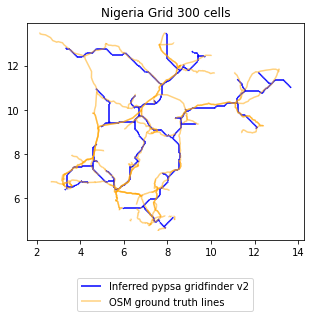

In [ ]:
fig = plt.figure(figsize=(12, 10))
ax = lines_guess_gdf_stoch.plot(color = 'blue', label = 'Inferred pypsa gridfinder v2')
ng_line_df.plot(ax = ax, color = 'orange', alpha = .5, label = 'OSM ground truth lines')
ax.legend(loc = 'center',bbox_to_anchor=(0.5, -0.25) )
ax.set_title("Nigeria Grid 300 cells")

In [ ]:
true_pos, false_neg = inference_accuracy(lines_guess_gdf_stoch, ng_line_df, n_cells)

print(f'Points identified as grid that are grid: {100*true_pos:.0f}%')
print(f'Actual grid that was missed: {100*false_neg:.0f}%')

##1000 cells

In [ ]:
n_cells = 1000
twr_df = ng_twr_df

network_guess_stoch, thinned_network_guess_stoch = network_inference_array_v2(twr_df, n_cells, random_start = True)


lines_guess_gdf_stoch = convert_guess_to_gdf_multilines(thinned_network_guess_stoch, twr_df, n_cells)

__main__:19: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
__main__:21: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: +proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 + ...



'99.00 %'

In [ ]:
network_guess_stoch

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

Text(0.5, 1.0, 'Nigeria Grid 1000 cells')

<Figure size 864x720 with 0 Axes>

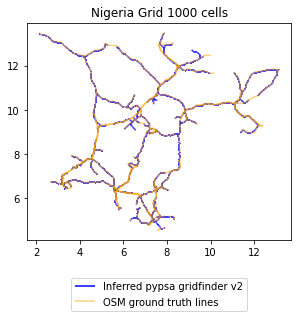

In [ ]:
fig = plt.figure(figsize=(12, 10))
ax = lines_guess_gdf_stoch.plot(color = 'blue', label = 'Inferred pypsa gridfinder v2')
ng_line_df.plot(ax = ax, color = 'orange', alpha = .5, label = 'OSM ground truth lines')
ax.legend(loc = 'center',bbox_to_anchor=(0.5, -0.25) )
ax.set_title("Nigeria Grid 1000 cells")

In [ ]:
true_pos, false_neg = inference_accuracy(lines_guess_gdf_stoch, ng_line_df, n_cells)

print(f'Points identified as grid that are grid: {100*true_pos:.0f}%')
print(f'Actual grid that was missed: {100*false_neg:.0f}%')